In [1]:
from platform import python_version

assert (
    python_version() == "3.11.0"
), "Running on other python version may cause problems"

In [2]:
from itertools import product
import os
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

In [3]:
TEXPS = np.arange(2.0, 9.1, 0.5)
RB_CURRENTS = np.array([3.2])

TARGET_INDICES = np.array(
    [
        22,
        23,
        24,
        25,
        26,
        27,
        32,
        33,
        36,
        37,
        38,
        39,
        40,
        43,
        44,
        45,
        46,
        47,
        48,
        49,
        52,
        53,
        54,
        55,
        56,
        59,
        60,
        61,
        62,
        63,
        64,
        65,
        68,
        69,
        70,
        71,
        72,
        75,
        76,
        81,
        82,
        83,
        84,
        85,
        86,
    ]
)
# 20 perepherial + 25 center = 45
assert TARGET_INDICES.shape[0] == 45, "Wrong traps alignment"
TARGET_INDICES

array([22, 23, 24, 25, 26, 27, 32, 33, 36, 37, 38, 39, 40, 43, 44, 45, 46,
       47, 48, 49, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 64, 65, 68, 69,
       70, 71, 72, 75, 76, 81, 82, 83, 84, 85, 86])

In [4]:
DATA_PROCESSED_PATH = Path(".", "..", "data", "preprocessed")
CUT_TRAPS_PATH = DATA_PROCESSED_PATH / "cut_traps.hdf5"

# Load data and implement labeling pipeline

In [5]:
arr_first = []
arr_third = []
rb_current = 3.2
trap_ind = 55

with h5py.File(CUT_TRAPS_PATH, "r", driver="split") as f:
    for texp in tqdm(TEXPS):
        d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/first/trap_{trap_ind}"]
        arr_first.append(d[::])

        d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/third/trap_{trap_ind}"]
        arr_third.append(d[::])

arr_first = np.concatenate(arr_first)
arr_third = np.concatenate(arr_third)
arr_first.shape, arr_third.shape

100%|██████████| 15/15 [00:00<00:00, 767.29it/s]


((15000, 8, 8), (15000, 8, 8))

##  Choose integral threshold value for images I1 and I3

In [6]:
# Sum of pixels threshold for images I1 and I3
INTEGRAL_THRESHOLD = 2400

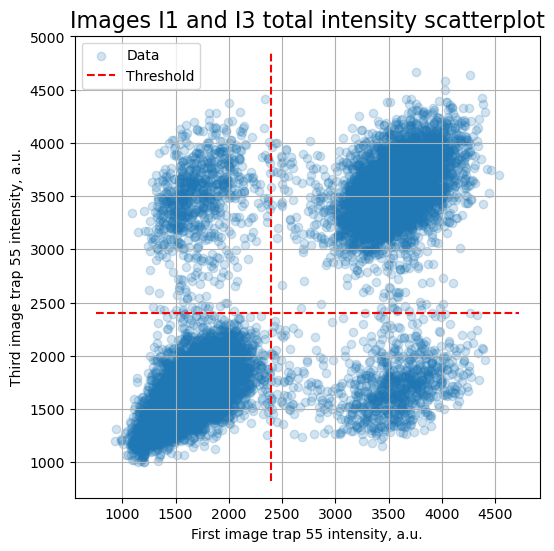

In [7]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(
    arr_first.sum(axis=(1, 2)),
    arr_third.sum(axis=(1, 2)),
    alpha=0.2,
    label="Data",
)
plt.vlines(
    INTEGRAL_THRESHOLD,
    plt.ylim()[0],
    plt.ylim()[1],
    color="red",
    linestyles="dashed",
    label="Threshold",
)
plt.hlines(
    INTEGRAL_THRESHOLD,
    plt.xlim()[0],
    plt.xlim()[1],
    color="red",
    linestyles="dashed",
)
plt.xlabel(f"First image trap {trap_ind} intensity, a.u.")
plt.ylabel(f"Third image trap {trap_ind} intensity, a.u.")
plt.title("Images I1 and I3 total intensity scatterplot", fontsize=16)
plt.gca().axis("equal")
plt.grid()
plt.legend()
plt.show()

In [8]:
np.array(
    [
        [
            (
                (arr_first.sum(axis=(1, 2)) < INTEGRAL_THRESHOLD)
                & (arr_third.sum(axis=(1, 2)) >= INTEGRAL_THRESHOLD)
            ).sum(),
            (
                (arr_first.sum(axis=(1, 2)) >= INTEGRAL_THRESHOLD)
                & (arr_third.sum(axis=(1, 2)) >= INTEGRAL_THRESHOLD)
            ).sum(),
        ],
        [
            (
                (arr_first.sum(axis=(1, 2)) < INTEGRAL_THRESHOLD)
                & (arr_third.sum(axis=(1, 2)) < INTEGRAL_THRESHOLD)
            ).sum(),
            (
                (arr_first.sum(axis=(1, 2)) >= INTEGRAL_THRESHOLD)
                & (arr_third.sum(axis=(1, 2)) < INTEGRAL_THRESHOLD)
            ).sum(),
        ],
    ]
)

array([[ 806, 4888],
       [8466,  840]])

In [9]:
arr_filled_first = np.zeros((TARGET_INDICES.shape[0], 1000), dtype=bool)
(
    arr_filled_third,
    arr_empty_first,
    arr_empty_third,
    arr_filled_second,
    arr_empty_second,
) = (
    np.zeros_like(arr_filled_first, dtype=bool),
    np.zeros_like(arr_filled_first, dtype=bool),
    np.zeros_like(arr_filled_first, dtype=bool),
    np.zeros_like(arr_filled_first, dtype=bool),
    np.zeros_like(arr_filled_first, dtype=bool),
)

In [10]:
texp = 9.0

def load_data_from_hdf5(
    trap_ind: int,
    filename: Path = CUT_TRAPS_PATH,
    rb_current: float = 3.2,
    texp: float = 8.0,
):
    arr_first = []
    arr_second = []
    arr_third = []

    with h5py.File(filename, "r", driver="split") as f:
        d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/first/trap_{trap_ind}"]
        arr_first.append(d[::])

        d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/second/trap_{trap_ind}"]
        arr_second.append(d[::])

        d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/third/trap_{trap_ind}"]
        arr_third.append(d[::])

    arr_first = np.concatenate(arr_first)
    arr_second = np.concatenate(arr_second)
    arr_third = np.concatenate(arr_third)
    return arr_first, arr_second, arr_third

## Make sure that chosen threshold is OK for each trap (should divide two peaks)

0it [00:00, ?it/s]

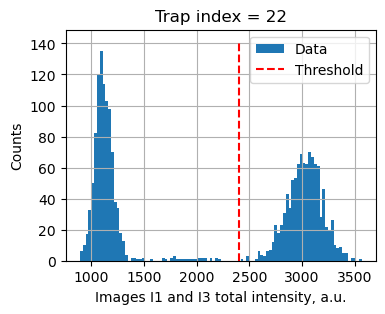

1it [00:00,  8.32it/s]

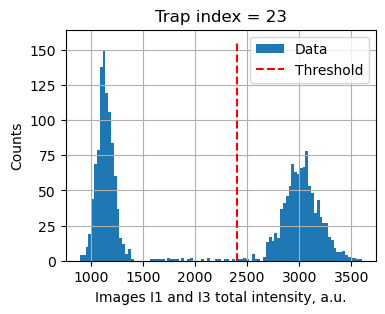

2it [00:00,  8.71it/s]

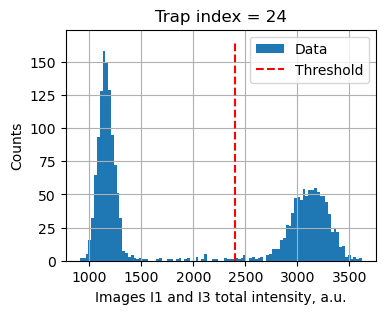

3it [00:00,  8.85it/s]

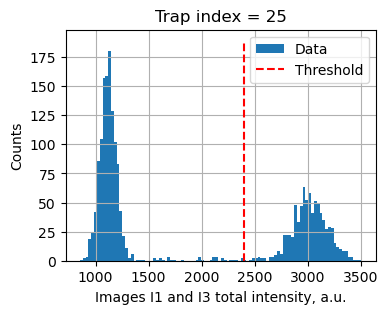

4it [00:00,  7.49it/s]

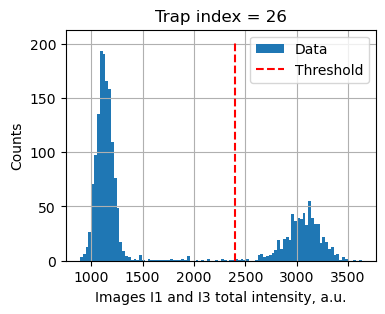

5it [00:00,  7.87it/s]

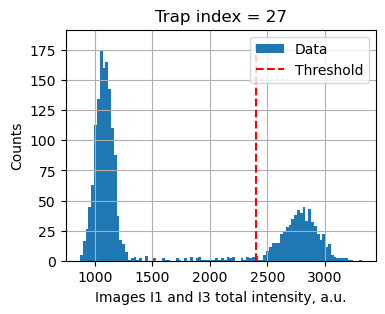

6it [00:00,  8.12it/s]

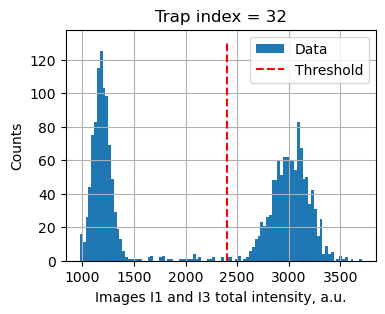

7it [00:00,  8.27it/s]

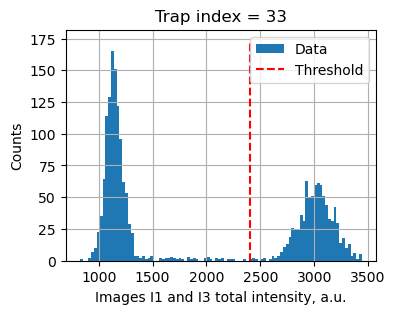

8it [00:00,  8.36it/s]

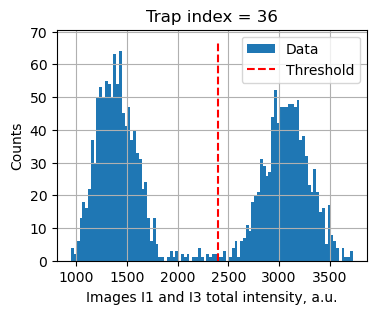

9it [00:01,  8.49it/s]

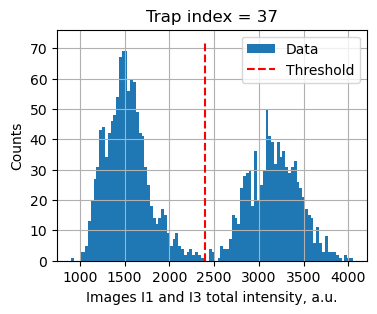

10it [00:01,  8.57it/s]

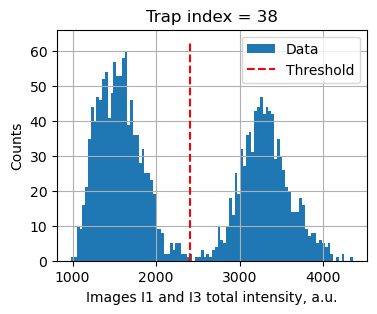

11it [00:01,  8.73it/s]

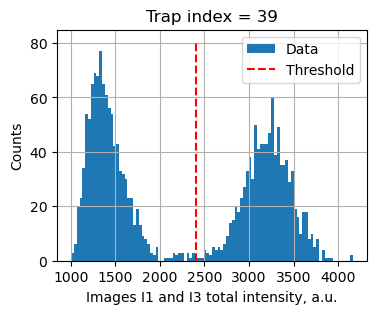

12it [00:01,  7.30it/s]

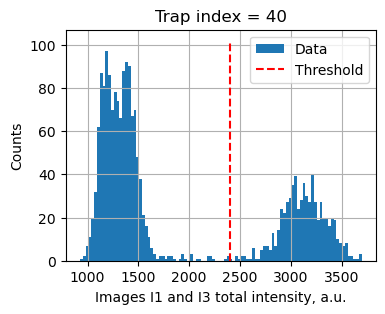

13it [00:01,  7.73it/s]

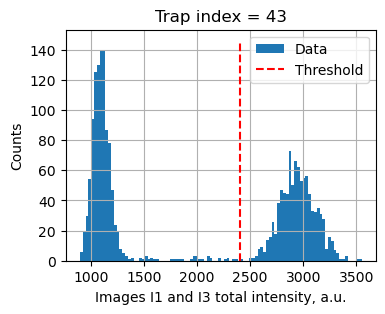

14it [00:01,  7.99it/s]

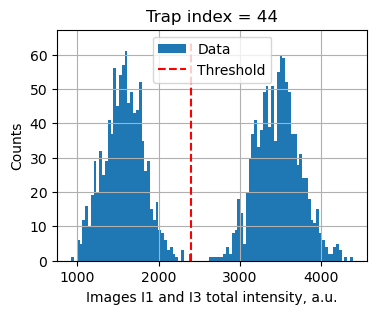

15it [00:01,  8.24it/s]

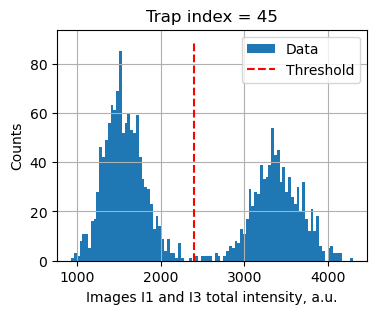

16it [00:01,  8.57it/s]

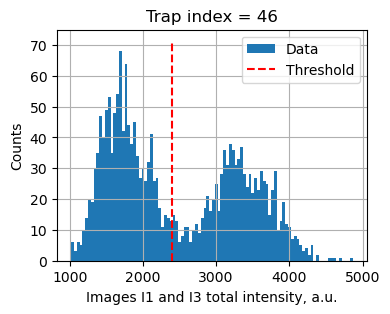

17it [00:02,  8.63it/s]

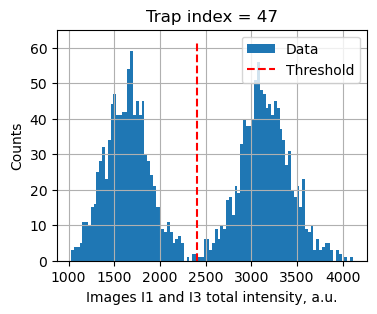

18it [00:02,  8.53it/s]

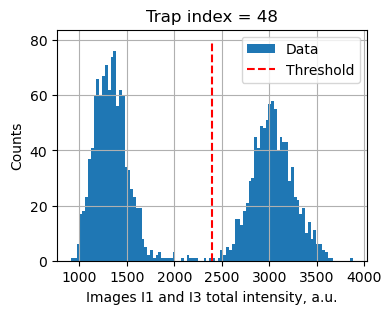

19it [00:02,  8.65it/s]

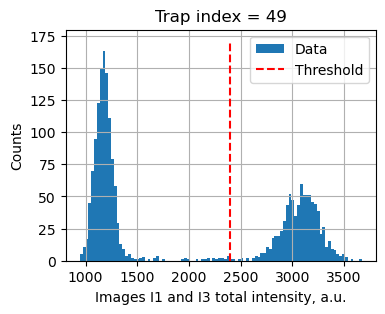

20it [00:02,  8.73it/s]

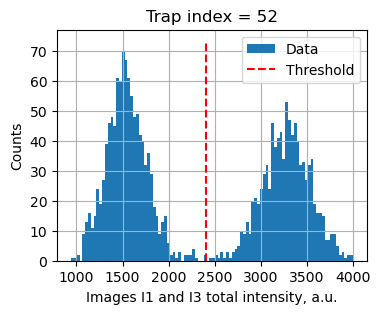

21it [00:02,  7.12it/s]

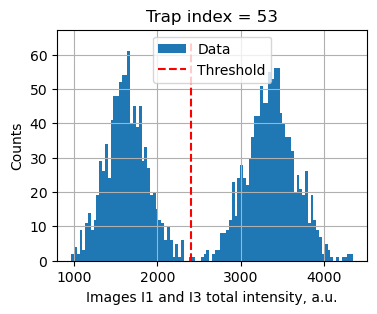

22it [00:02,  7.57it/s]

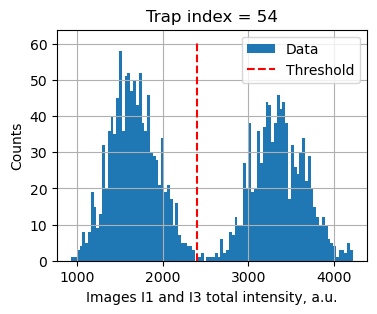

23it [00:02,  7.97it/s]

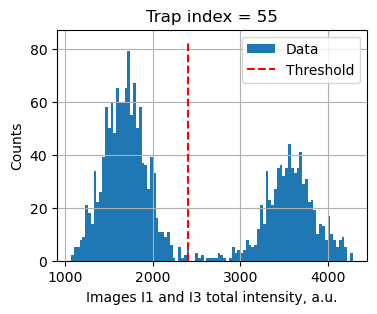

24it [00:02,  8.39it/s]

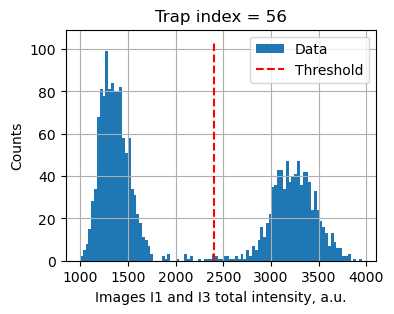

25it [00:03,  8.61it/s]

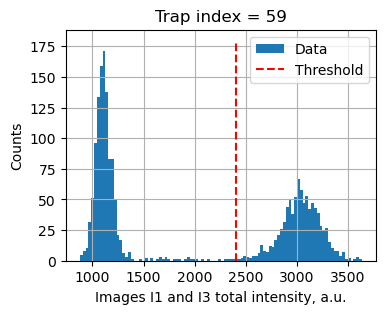

26it [00:03,  8.60it/s]

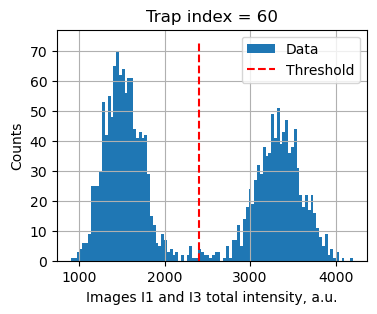

27it [00:03,  8.69it/s]

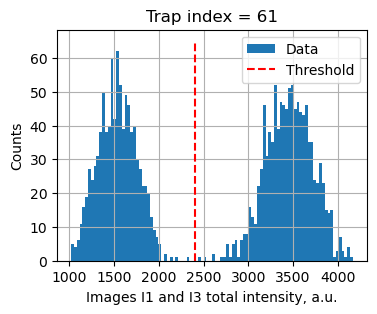

28it [00:03,  8.67it/s]

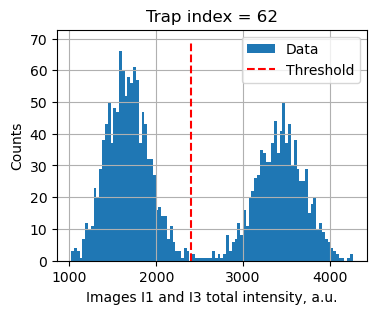

29it [00:03,  8.70it/s]

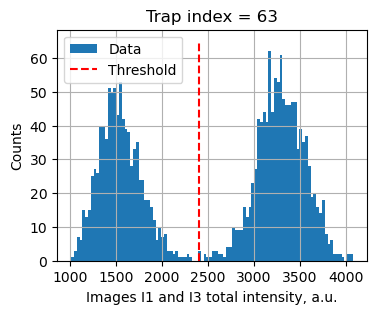

30it [00:03,  7.08it/s]

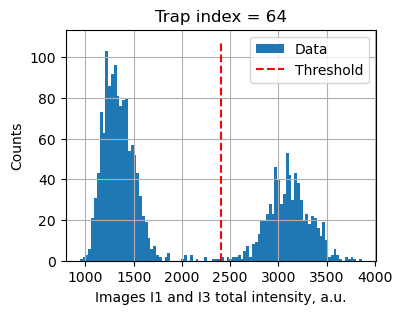

31it [00:03,  7.54it/s]

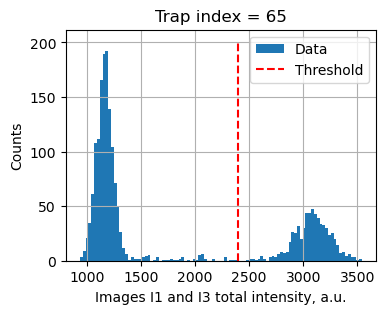

32it [00:03,  7.91it/s]

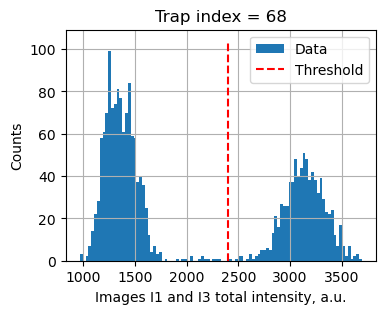

33it [00:04,  8.18it/s]

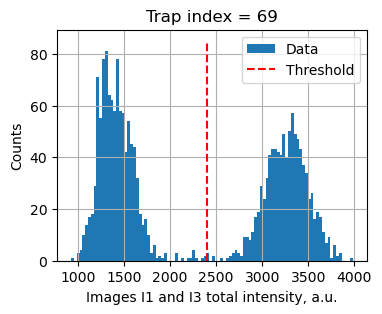

34it [00:04,  8.41it/s]

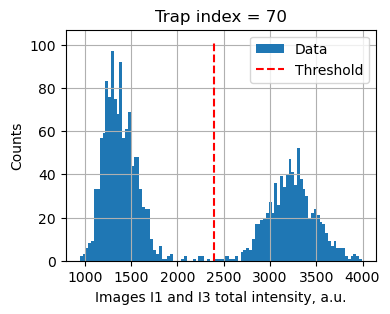

35it [00:04,  8.46it/s]

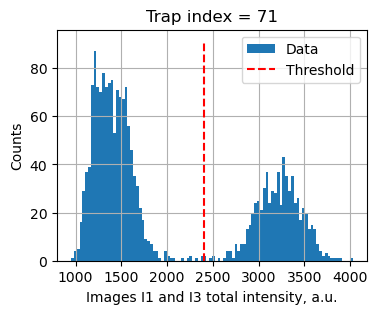

36it [00:04,  8.57it/s]

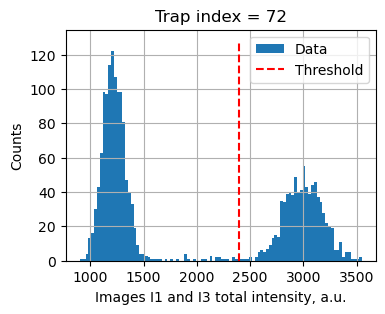

37it [00:04,  7.92it/s]

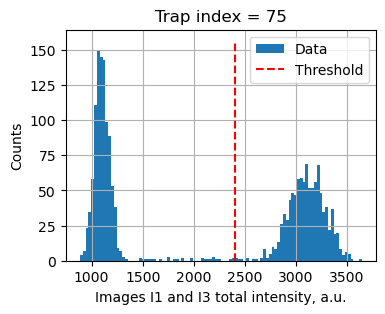

38it [00:04,  6.76it/s]

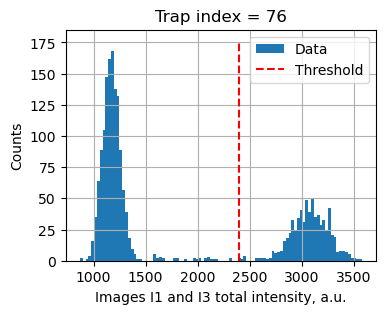

39it [00:04,  7.22it/s]

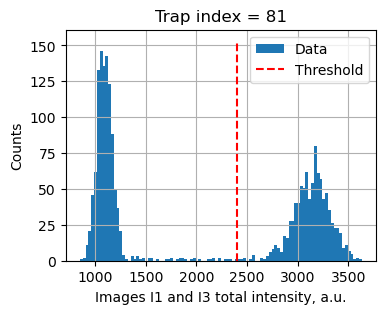

40it [00:04,  7.54it/s]

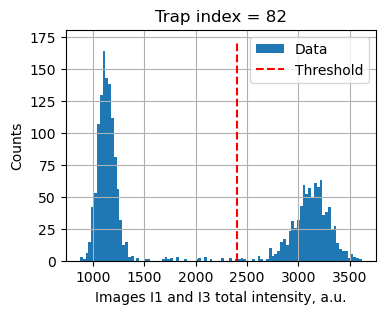

41it [00:05,  7.76it/s]

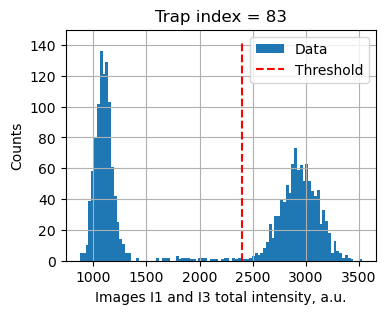

42it [00:05,  8.03it/s]

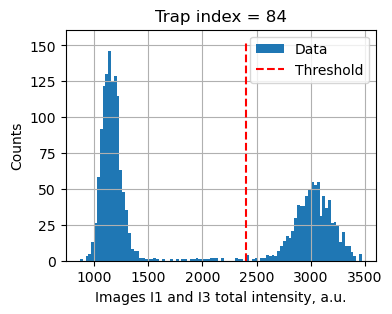

43it [00:05,  8.25it/s]

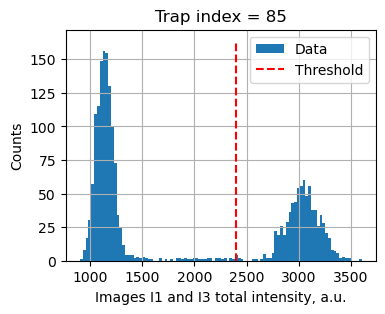

44it [00:05,  8.38it/s]

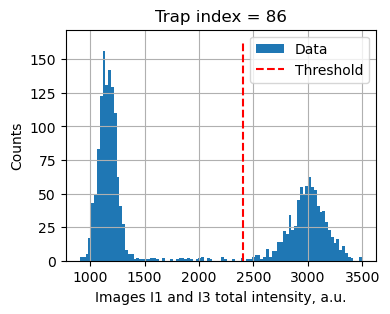

45it [00:05,  8.13it/s]


In [11]:
for ind, trap_ind in tqdm(enumerate(TARGET_INDICES)):
    arr_first, arr_second, arr_third = load_data_from_hdf5(trap_ind=trap_ind, texp=texp, rb_current=rb_current)

    s1 = arr_first.sum(axis=(1, 2))
    arr_filled_first[ind] = s1 >= INTEGRAL_THRESHOLD
    arr_empty_first[ind] = s1 <= INTEGRAL_THRESHOLD

    s3 = arr_third.sum(axis=(1, 2))
    arr_filled_third[ind] = s3 >= INTEGRAL_THRESHOLD
    arr_empty_third[ind] = s3 <= INTEGRAL_THRESHOLD

    arr_filled_second[ind] = arr_filled_first[ind] & arr_filled_third[ind]
    arr_empty_second[ind] = arr_empty_first[ind] & arr_empty_third[ind]

    fig = plt.figure(figsize=(4, 3))
    plt.hist(np.concatenate((arr_first, arr_third)).sum(axis=(1, 2)), bins=100, label="Data")
    plt.grid()
    plt.title(f"Trap index = {trap_ind}")
    plt.vlines(
        INTEGRAL_THRESHOLD,
        plt.ylim()[0],
        plt.ylim()[1],
        color="red",
        linestyles="dashed",
        label="Threshold",
    )
    plt.xlabel(f"Images I1 and I3 total intensity, a.u.")
    plt.ylabel(f"Counts")
    plt.legend()
    plt.show()

## View classes balance

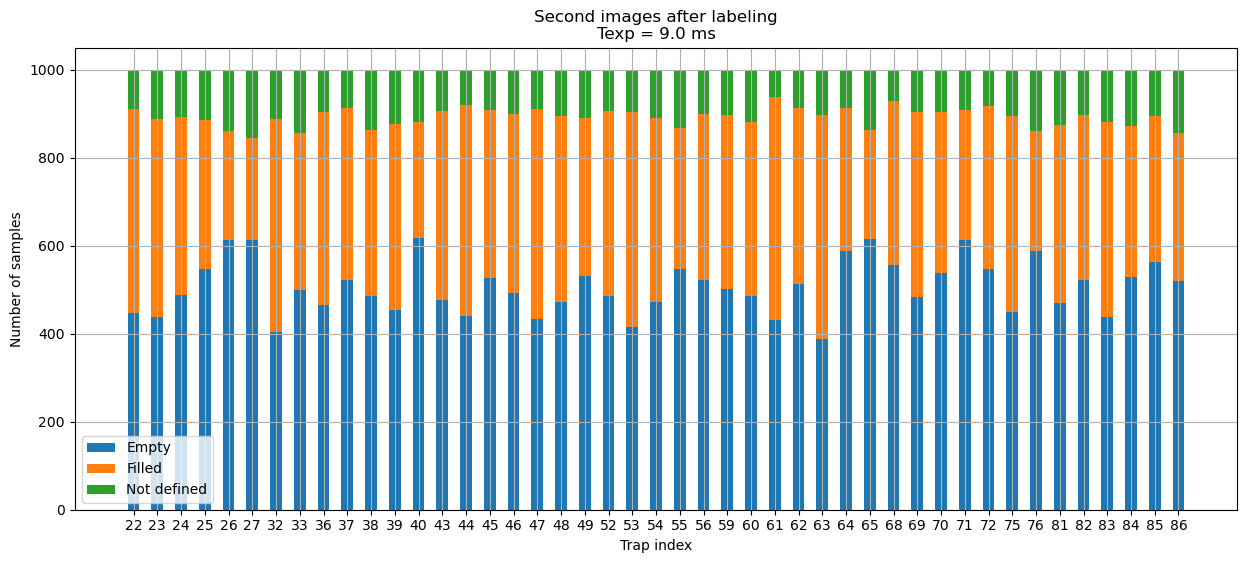

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.bar(
    x=np.arange(TARGET_INDICES.shape[0]),
    height=arr_empty_second.sum(axis=1),
    bottom=0,
    label="Empty",
    width=0.5,
)
ax.bar(
    x=np.arange(TARGET_INDICES.shape[0]),
    height=arr_filled_second.sum(axis=1),
    bottom=arr_empty_second.sum(axis=1),
    label="Filled",
    width=0.5,
)
ax.bar(
    x=np.arange(TARGET_INDICES.shape[0]),
    height=arr_empty_second.shape[1]
    - arr_filled_second.sum(axis=1)
    - arr_empty_second.sum(axis=1),
    bottom=arr_filled_second.sum(axis=1) + arr_empty_second.sum(axis=1),
    label="Not defined",
    width=0.5,
)
ax.set_xticks(np.arange(TARGET_INDICES.shape[0]), labels=TARGET_INDICES)
ax.set_xlabel("Trap index")
ax.set_ylabel("Number of samples")
ax.set_title(f"Second images after labeling\nTexp = {texp} ms")
plt.grid()
plt.legend()
plt.show()

## Some data is mislabeled => we need to filter outliers 

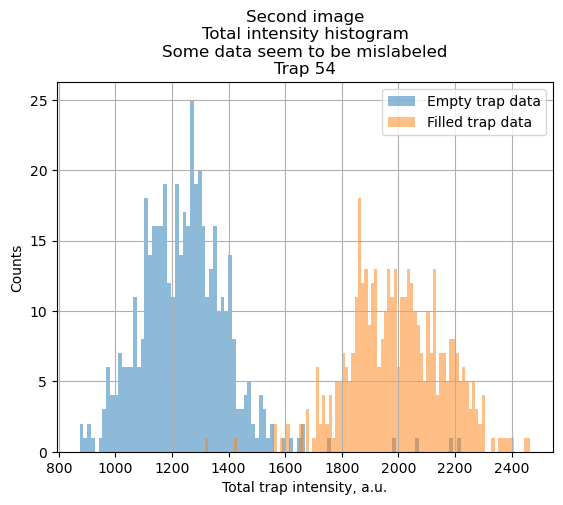

In [13]:
INDEX = 22
arr_first, arr_second, arr_third = load_data_from_hdf5(
    trap_ind=TARGET_INDICES[INDEX], texp=texp, rb_current=rb_current
)

fig = plt.figure()
dat = np.concatenate(
    [
        arr_second[arr_empty_second[INDEX]].sum(axis=(1, 2)),
        arr_second[arr_filled_second[INDEX]].sum(axis=(1, 2)),
    ]
)
h = scipy.stats.iqr(dat) * 2 * dat.shape[0] ** (-1 / 3)

plt.hist(
    arr_second[arr_empty_second[INDEX]].sum(axis=(1, 2)),
    bins=100,
    alpha=0.5,
    label="Empty trap data",
    color="C0",
)
plt.hist(
    arr_second[arr_filled_second[INDEX]].sum(axis=(1, 2)),
    bins=100,
    alpha=0.5,
    label="Filled trap data",
    color="C1",
)
plt.grid()
plt.legend()
plt.xlabel("Total trap intensity, a.u.")
plt.ylabel("Counts")
plt.title(
    f"Second image\nTotal intensity histogram\nSome data seem to be mislabeled\nTrap {TARGET_INDICES[INDEX]}"
)
plt.show()

## Filter data outliers using 1.5 IQR criterion

In [14]:
IQR_CONST_FACTOR = 1.5

arr_filled_clean = arr_second[arr_filled_second[INDEX]].copy().sum(axis=(1, 2))

# filled
iqr_filled = scipy.stats.iqr(arr_filled_clean)
median_filled = np.median(arr_filled_clean)
filled_inds = (
    np.quantile(arr_filled_clean, q=0.25) - IQR_CONST_FACTOR * iqr_filled
    <= arr_filled_clean
) & (
    arr_filled_clean
    <= np.quantile(arr_filled_clean, q=0.75) + IQR_CONST_FACTOR * iqr_filled
)
arr_filled_clean = arr_filled_clean[filled_inds,]

arr_empty_clean = arr_second[arr_empty_second[INDEX]].copy().sum(axis=(1, 2))

# empty
iqr_empty = scipy.stats.iqr(arr_empty_clean)
median_empty = np.median(arr_empty_clean)
empty_inds = (
    np.quantile(arr_empty_clean, q=0.25) - IQR_CONST_FACTOR * iqr_empty
    <= arr_empty_clean
) & (
    arr_empty_clean
    <= np.quantile(arr_empty_clean, q=0.75) + IQR_CONST_FACTOR * iqr_empty
)
arr_empty_clean = arr_empty_clean[empty_inds,]

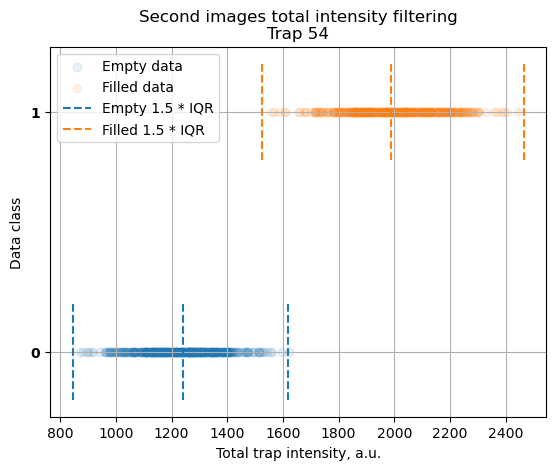

In [15]:
fig = plt.figure()
plt.scatter(
    arr_empty_clean,
    np.zeros(arr_empty_clean.shape[0]),
    alpha=0.1,
    color="C0",
    label="Empty data"
)
plt.scatter(
    arr_filled_clean,
    np.ones(arr_filled_clean.shape[0]),
    alpha=0.1,
    color="C1",
    label="Filled data"
)
plt.vlines(
    [
        np.quantile(arr_empty_clean, q=0.25) - IQR_CONST_FACTOR * iqr_empty,
        median_empty,
        np.quantile(arr_empty_clean, q=0.75) + IQR_CONST_FACTOR * iqr_empty,
    ],
    -0.2,
    0.2,
    label=f"Empty {IQR_CONST_FACTOR} * IQR",
    linestyle="dashed",
    color="C0",
)
plt.vlines(
    [
        np.quantile(arr_filled_clean, q=0.25) - IQR_CONST_FACTOR * iqr_filled,
        median_filled,
        np.quantile(arr_filled_clean, q=0.75) + IQR_CONST_FACTOR * iqr_filled,
    ],
    0.8,
    1.2,
    label=f"Filled {IQR_CONST_FACTOR} * IQR",
    linestyle="dashed",
    color="C1",
)
plt.grid()
plt.legend()
plt.xlabel("Total trap intensity, a.u.")
plt.ylabel("Data class")
plt.yticks([0, 1], labels=[r"$\mathbf{0}$", r"$\mathbf{1}$"], )
plt.title(f"Second images total intensity filtering\nTrap {TARGET_INDICES[INDEX]}")
plt.show()

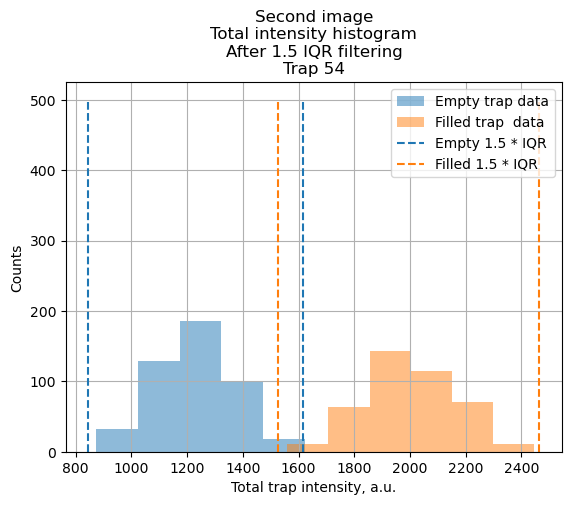

In [16]:
fig = plt.figure()
dat = np.concatenate([arr_empty_clean, arr_filled_clean])
h = scipy.stats.iqr(dat) * 2 * dat.shape[0] ** (-1 / 3)

plt.hist(
    arr_empty_clean,
    bins=round((arr_empty_clean.max() - arr_empty_clean.min()) / h),
    alpha=0.5,
    label="Empty trap data",
    color="C0",
)
plt.hist(
    arr_filled_clean,
    bins=round((arr_filled_clean.max() - arr_filled_clean.min()) / h),
    alpha=0.5,
    label="Filled trap  data",
    color="C1",
)
plt.vlines(
    [
        np.quantile(arr_empty_clean, q=0.25) - IQR_CONST_FACTOR * iqr_empty,
        # median_empty,
        np.quantile(arr_empty_clean, q=0.75) + IQR_CONST_FACTOR * iqr_empty,
    ],
    0,
    500,
    label=f"Empty {IQR_CONST_FACTOR} * IQR",
    linestyle="dashed",
    color="C0",
)
plt.vlines(
    [
        np.quantile(arr_filled_clean, q=0.25) - IQR_CONST_FACTOR * iqr_filled,
        # median_filled,
        np.quantile(arr_filled_clean, q=0.75) + IQR_CONST_FACTOR * iqr_filled,
    ],
    0,
    500,
    label=f"Filled {IQR_CONST_FACTOR} * IQR",
    linestyle="dashed",
    color="C1",
)
plt.grid()
plt.legend()
plt.xlabel("Total trap intensity, a.u.")
plt.ylabel("Counts")
plt.title(
    f"Second image\nTotal intensity histogram\nAfter 1.5 IQR filtering\nTrap {TARGET_INDICES[INDEX]}"
)
# plt.savefig("hist_after_filtering.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Apply labeling pipeline to each trap data

In [17]:
LABELED_TRAPS_PATH = DATA_PROCESSED_PATH / "labeled_traps.hdf5"

try:
    os.remove(LABELED_TRAPS_PATH)
    print(f"File '{LABELED_TRAPS_PATH}' has been removed.")
except:
    print(f"File '{LABELED_TRAPS_PATH}' does not exist.")

File '../data/preprocessed/labeled_traps.hdf5' has been removed.


In [18]:
def process_data_return_clean_file(plot: bool = False):
    with h5py.File(LABELED_TRAPS_PATH, "a") as f:
        for rb_current, texp in tqdm(product(RB_CURRENTS, TEXPS), total=RB_CURRENTS.shape[0] * TEXPS.shape[0]):
            g = f.require_group(f"rb_{rb_current:.1f}")
            gg = g.require_group(f"texp_{texp:.1f}")

            arr_first_all = np.empty((0, 8, 8))
            arr_third_all = np.empty((0, 8, 8))

            arr_filled_first = np.zeros((TARGET_INDICES.shape[0], 1000), dtype=bool)

            filled_imgs = np.empty((0, 8, 8))
            empty_imgs = np.empty((0, 8, 8))
            for ind, trap_ind in enumerate(TARGET_INDICES):
                ggg = gg.require_group(f"trap_{trap_ind}")

                # load data
                arr_first, arr_second, arr_third = load_data_from_hdf5(
                    filename=CUT_TRAPS_PATH,
                    rb_current=rb_current,
                    texp=texp,
                    trap_ind=trap_ind,
                )

                # concat data
                arr_first_all = np.concatenate((arr_first_all, arr_first), axis=0)
                arr_third_all = np.concatenate((arr_third_all, arr_third), axis=0)

                # label images
                s1 = arr_first.sum(axis=(1, 2))
                arr_filled_first[ind] = s1 >= INTEGRAL_THRESHOLD
                arr_empty_first[ind] = s1 < INTEGRAL_THRESHOLD
                s3 = arr_third.sum(axis=(1, 2))
                arr_filled_third[ind] = s3 >= INTEGRAL_THRESHOLD
                arr_empty_third[ind] = s3 < INTEGRAL_THRESHOLD
                # get second images labels
                arr_filled_second[ind] = arr_filled_first[ind] & arr_filled_third[ind]
                arr_empty_second[ind] = arr_empty_first[ind] & arr_empty_third[ind]

                # filled
                filled_data = arr_second[arr_filled_second[ind]].copy()
                arr_filled_clean = filled_data.sum(axis=(1, 2))
                iqr_filled = scipy.stats.iqr(arr_filled_clean)
                median_filled = np.median(arr_filled_clean)

                #################### 1.5 IQR filtering begin ####################
                filled_inds = ( 
                    np.quantile(arr_filled_clean, q=0.25)
                    - IQR_CONST_FACTOR * iqr_filled
                    <= arr_filled_clean
                ) & (
                    arr_filled_clean
                    <= np.quantile(arr_filled_clean, q=0.75)
                    + IQR_CONST_FACTOR * iqr_filled
                )
                #################### 1.5 IQR filtering end ####################
                filled_imgs = np.concatenate(
                    (filled_imgs, filled_data[filled_inds]), axis=0
                )

                # empty
                empty_data = arr_second[arr_empty_second[ind]].copy()
                arr_empty_clean = empty_data.sum(axis=(1, 2))
                iqr_empty = scipy.stats.iqr(arr_empty_clean)
                median_empty = np.median(arr_empty_clean)

                #################### 1.5 IQR filtering begin ####################
                empty_inds = (
                    np.quantile(arr_empty_clean, q=0.25) - IQR_CONST_FACTOR * iqr_empty
                    <= arr_empty_clean
                ) & (
                    arr_empty_clean
                    <= np.quantile(arr_empty_clean, q=0.75)
                    + IQR_CONST_FACTOR * iqr_empty
                )
                #################### 1.5 IQR filtering end ####################
                empty_imgs = np.concatenate(
                    (empty_imgs, empty_data[empty_inds]), axis=0
                )

                # save dataset
                _ = ggg.create_dataset(
                    "filled",
                    data=filled_data[filled_inds],
                    compression="gzip",
                )
                _ = ggg.create_dataset(
                    "empty",
                    data=empty_data[empty_inds],
                    compression="gzip",
                )

            # plot data
            if plot:
                fig, ax = plt.subplots(
                    nrows=1, ncols=3, figsize=(30, 7), width_ratios=[1, 1.75, 1]
                )
                ax[0].scatter(
                    arr_first_all.sum(axis=(1, 2)),
                    arr_third_all.sum(axis=(1, 2)),
                    alpha=0.2,
                    label="Data",
                )
                ax[0].grid()
                ax[0].set_xlim((0, 2 * INTEGRAL_THRESHOLD))
                ax[0].set_ylim((0, 2 * INTEGRAL_THRESHOLD))
                ax[0].vlines(
                    INTEGRAL_THRESHOLD,
                    0,
                    2 * INTEGRAL_THRESHOLD,
                    color="red",
                    linestyles="dashed",
                    label="Threshold",
                )
                ax[0].hlines(
                    INTEGRAL_THRESHOLD,
                    0,
                    2 * INTEGRAL_THRESHOLD,
                    color="red",
                    linestyles="dashed",
                )
                ax[0].set_xlabel("First image intensity, a.u.", fontsize=14)
                ax[0].set_ylabel("Third image intensity, a.u.", fontsize=14)
                ax[0].set_title("Images I1 and I3 total intensity scatterplot", fontsize=16)
                ax[0].legend(fontsize=14)
                ax[0].axis("square")
                ax[0].tick_params(axis="both", which="major", labelsize=14)

                ax[1].bar(
                    x=np.arange(TARGET_INDICES.shape[0]),
                    height=arr_empty_second.sum(axis=1),
                    bottom=0,
                    label="Empty",
                    width=0.5,
                    color="C0"
                )
                ax[1].bar(
                    x=np.arange(TARGET_INDICES.shape[0]),
                    height=arr_filled_second.sum(axis=1),
                    bottom=arr_empty_second.sum(axis=1),
                    label="Filled",
                    width=0.5,
                    color="C1"
                )
                ax[1].bar(
                    x=np.arange(TARGET_INDICES.shape[0]),
                    height=arr_empty_second.shape[1]
                    - arr_filled_second.sum(axis=1)
                    - arr_empty_second.sum(axis=1),
                    bottom=arr_filled_second.sum(axis=1) + arr_empty_second.sum(axis=1),
                    label="Not defined",
                    width=0.5,
                    color="C2"
                )
                ax[1].set_xticks(
                    np.arange(TARGET_INDICES.shape[0]), labels=TARGET_INDICES
                )
                ax[1].set_xlabel("Trap index", fontsize=14)
                ax[1].set_ylabel("Number of samples", fontsize=14)
                ax[1].set_title(
                    f"Class balance after initial labeling",
                    fontsize=16
                )
                ax[1].grid()
                ax[1].legend(fontsize=14)
                ax[1].tick_params(axis="both", which="major", labelsize=14)

                dat = np.concatenate(
                    (filled_imgs.sum(axis=(1, 2)), empty_imgs.sum(axis=(1, 2))), axis=0
                )
                h = scipy.stats.iqr(dat) * 2 * dat.shape[0] ** (-1 / 3)
                ax[2].hist(
                    empty_imgs.sum(axis=(1, 2)),
                    bins=round((dat.max() - dat.min()) / h),
                    label="Empty",
                    alpha=0.5,
                    color="C0"
                )
                ax[2].hist(
                    filled_imgs.sum(axis=(1, 2)),
                    bins=round((dat.max() - dat.min()) / h),
                    label="Filled",
                    alpha=0.5,
                    color="C1"
                )
                ax[2].set_title(
                    "Labeled and filtered I2 images data total intensity histogram",
                    fontsize=16
                )
                ax[2].set_xlabel("Total trap intensity, a.u.", fontsize=14)
                ax[2].set_ylabel("Counts", fontsize=14)
                ax[2].grid()
                ax[2].legend(fontsize=14)
                ax[2].tick_params(axis="both", which="major", labelsize=14)
                
                plt.suptitle(
                    f"Rb current = {rb_current:.1f} A\n$T_\exp$ = {texp:.1f} ms",
                    fontsize=18
                )
                plt.tight_layout()
                plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

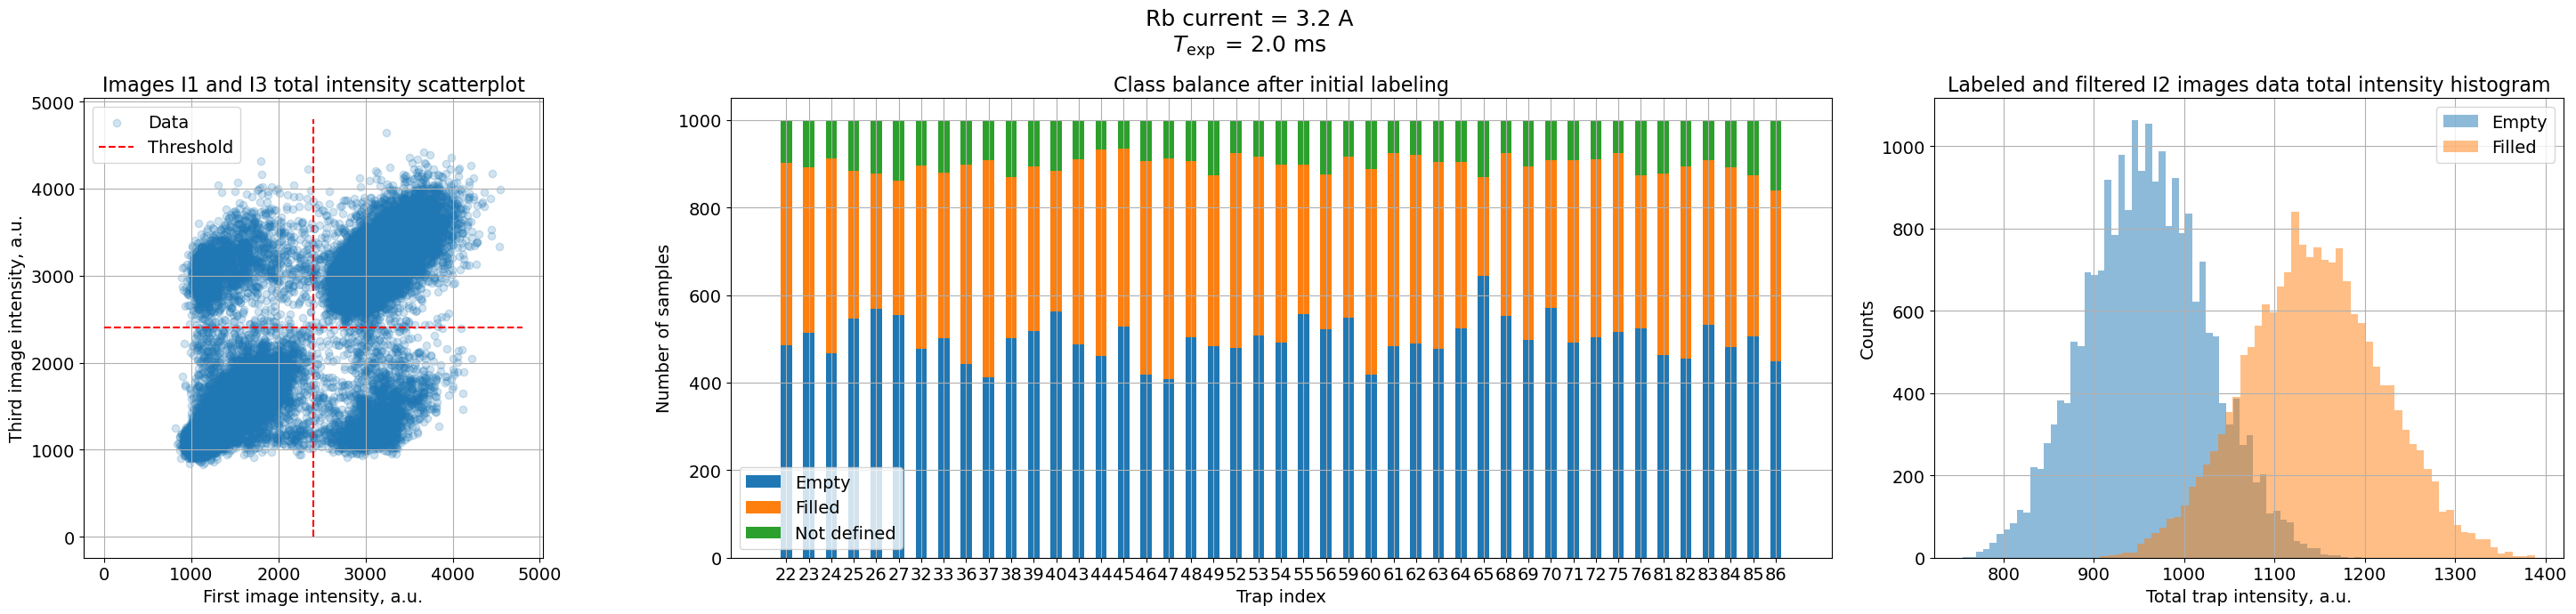

  7%|▋         | 1/15 [00:01<00:18,  1.31s/it]

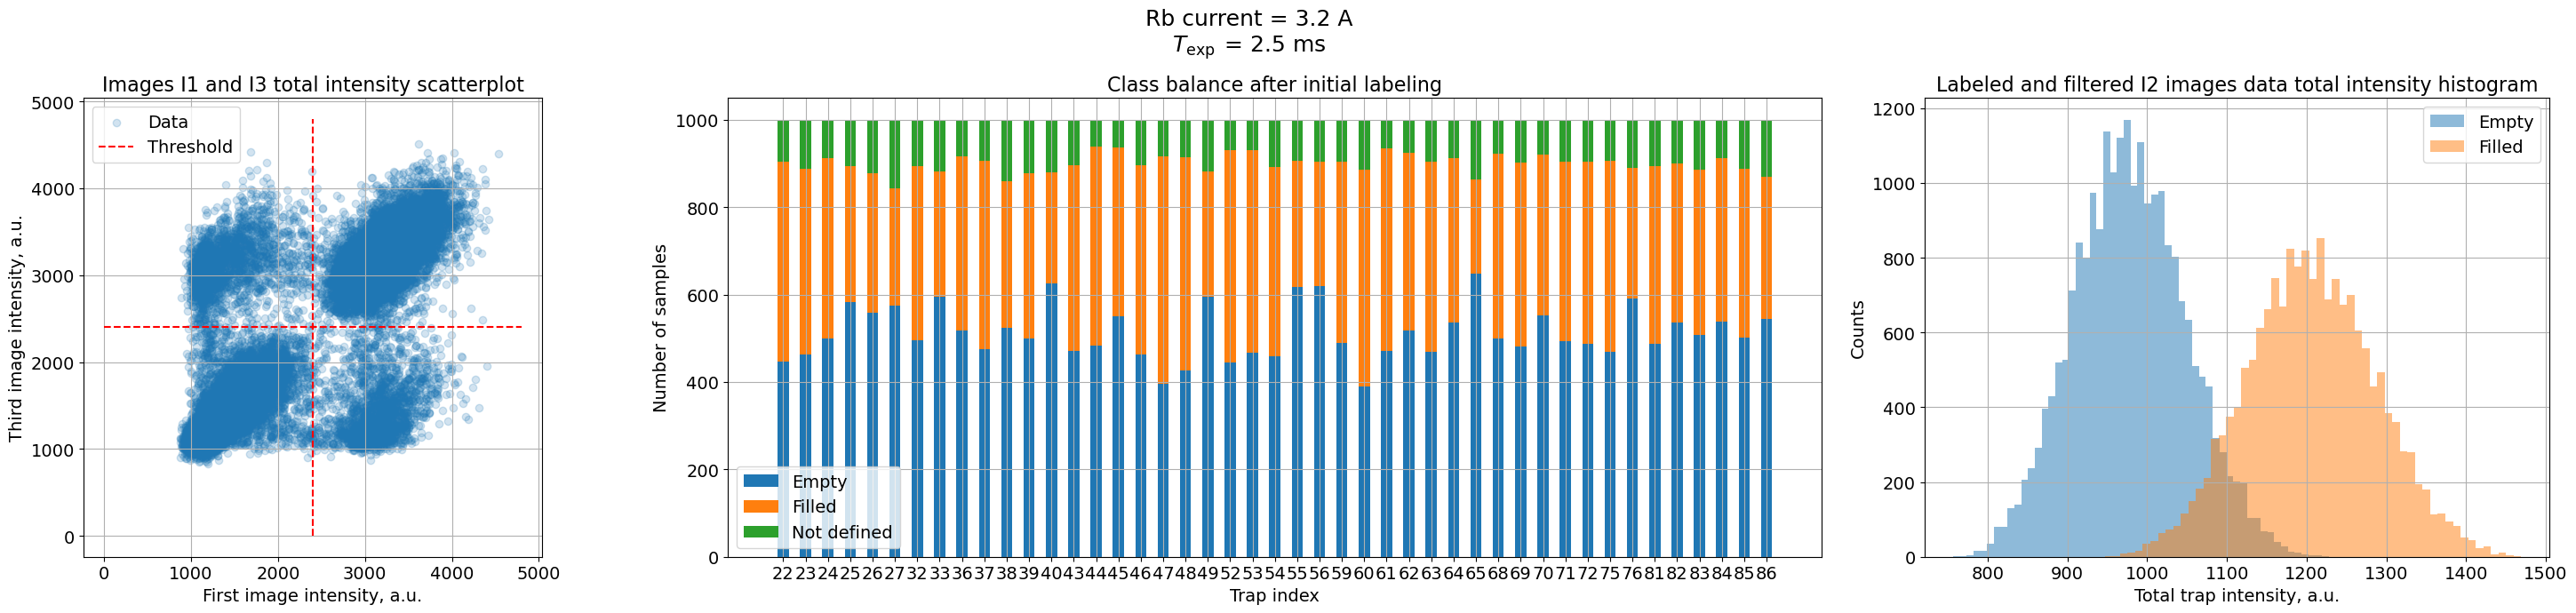

 13%|█▎        | 2/15 [00:02<00:16,  1.26s/it]

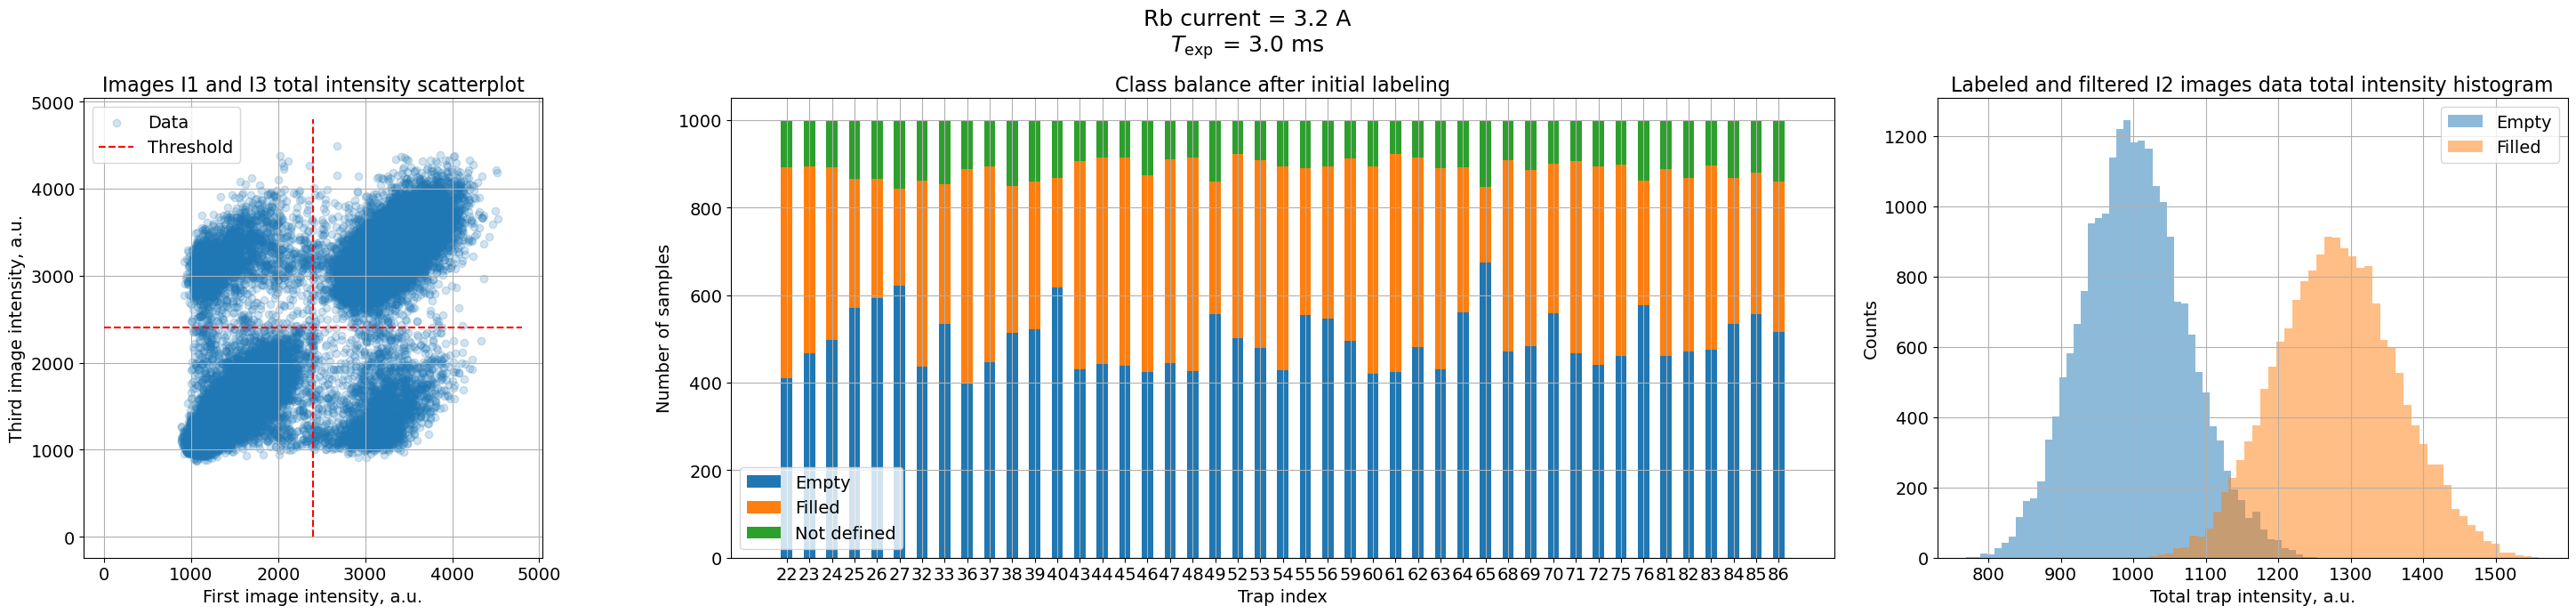

 20%|██        | 3/15 [00:03<00:14,  1.25s/it]

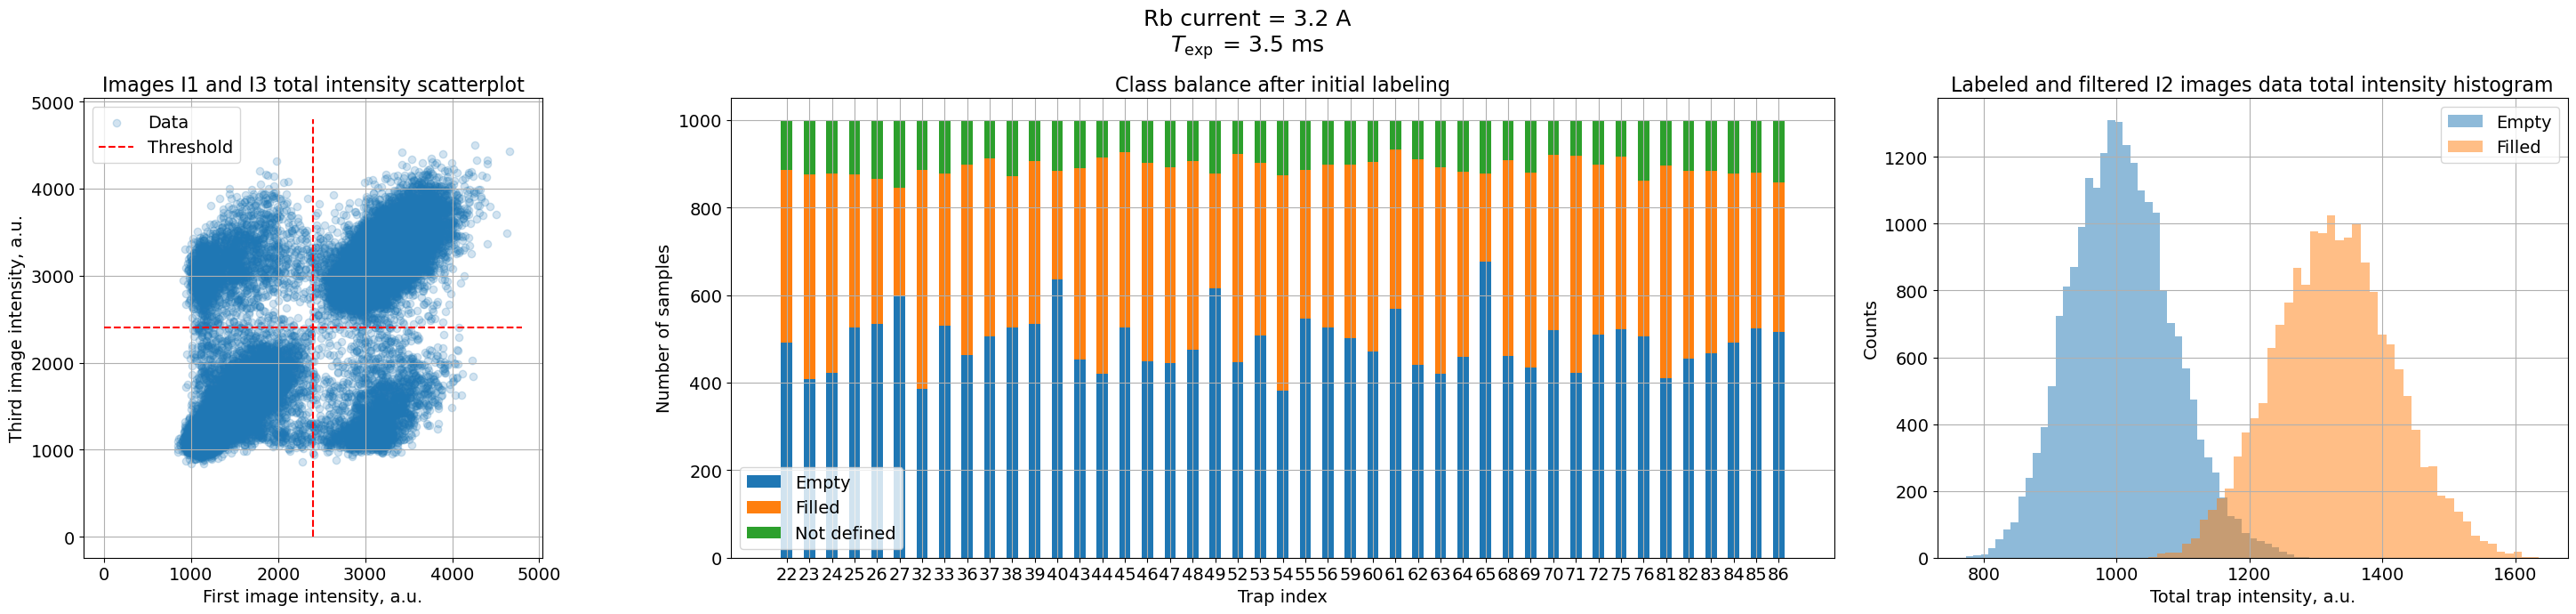

 27%|██▋       | 4/15 [00:04<00:13,  1.22s/it]

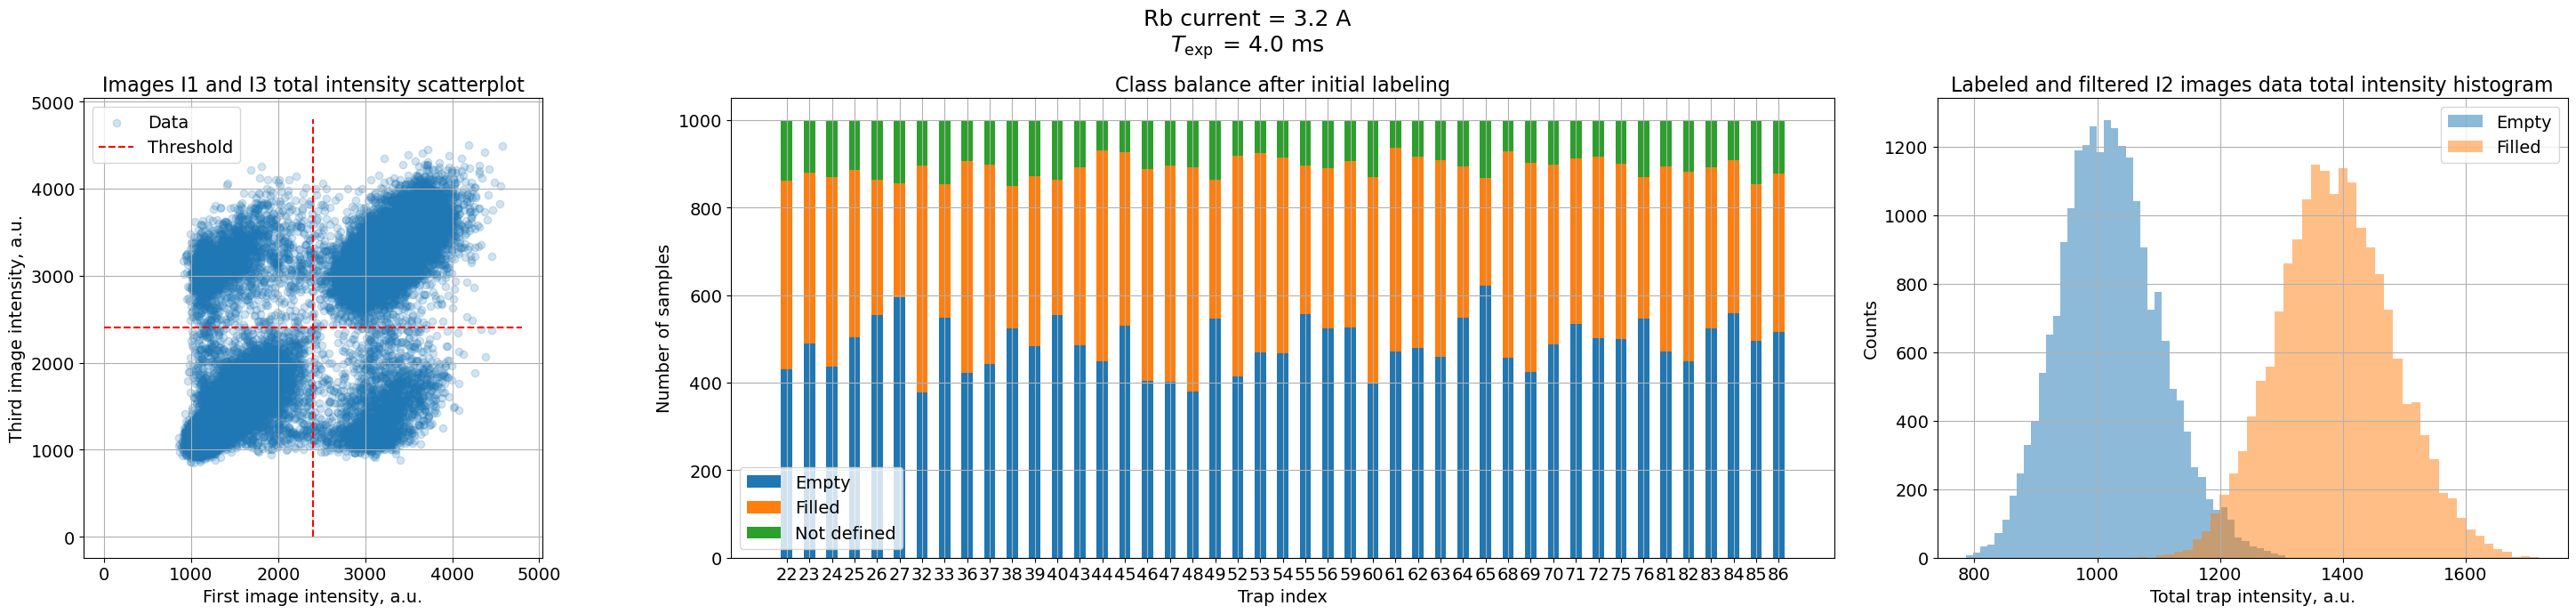

 33%|███▎      | 5/15 [00:06<00:12,  1.28s/it]

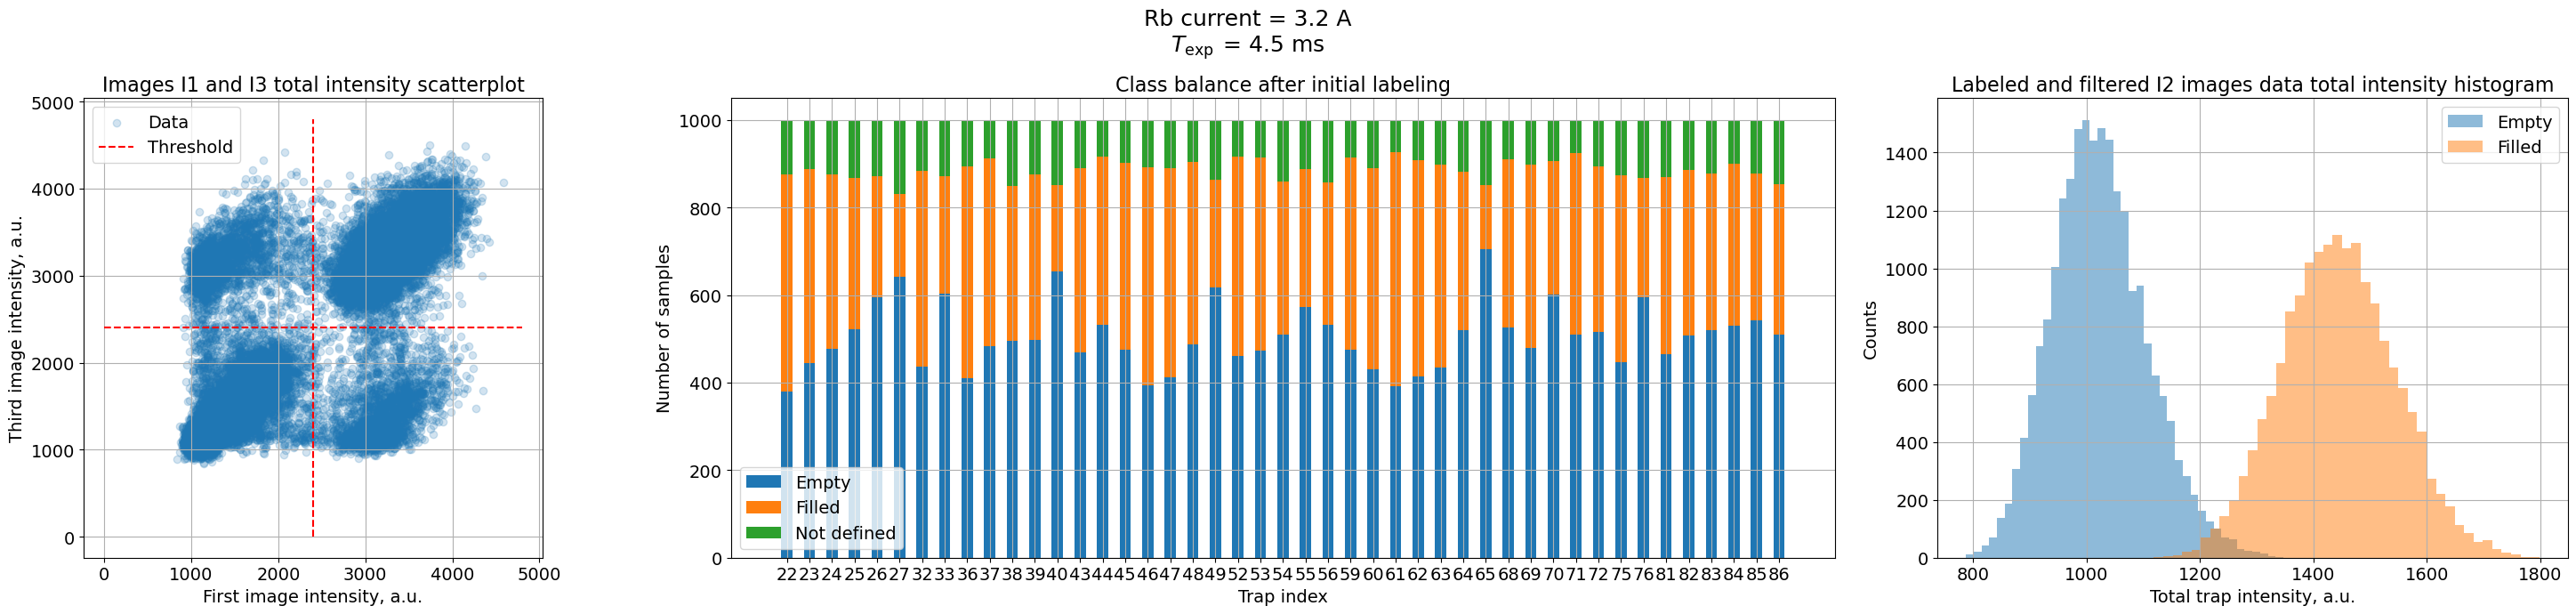

 40%|████      | 6/15 [00:07<00:11,  1.24s/it]

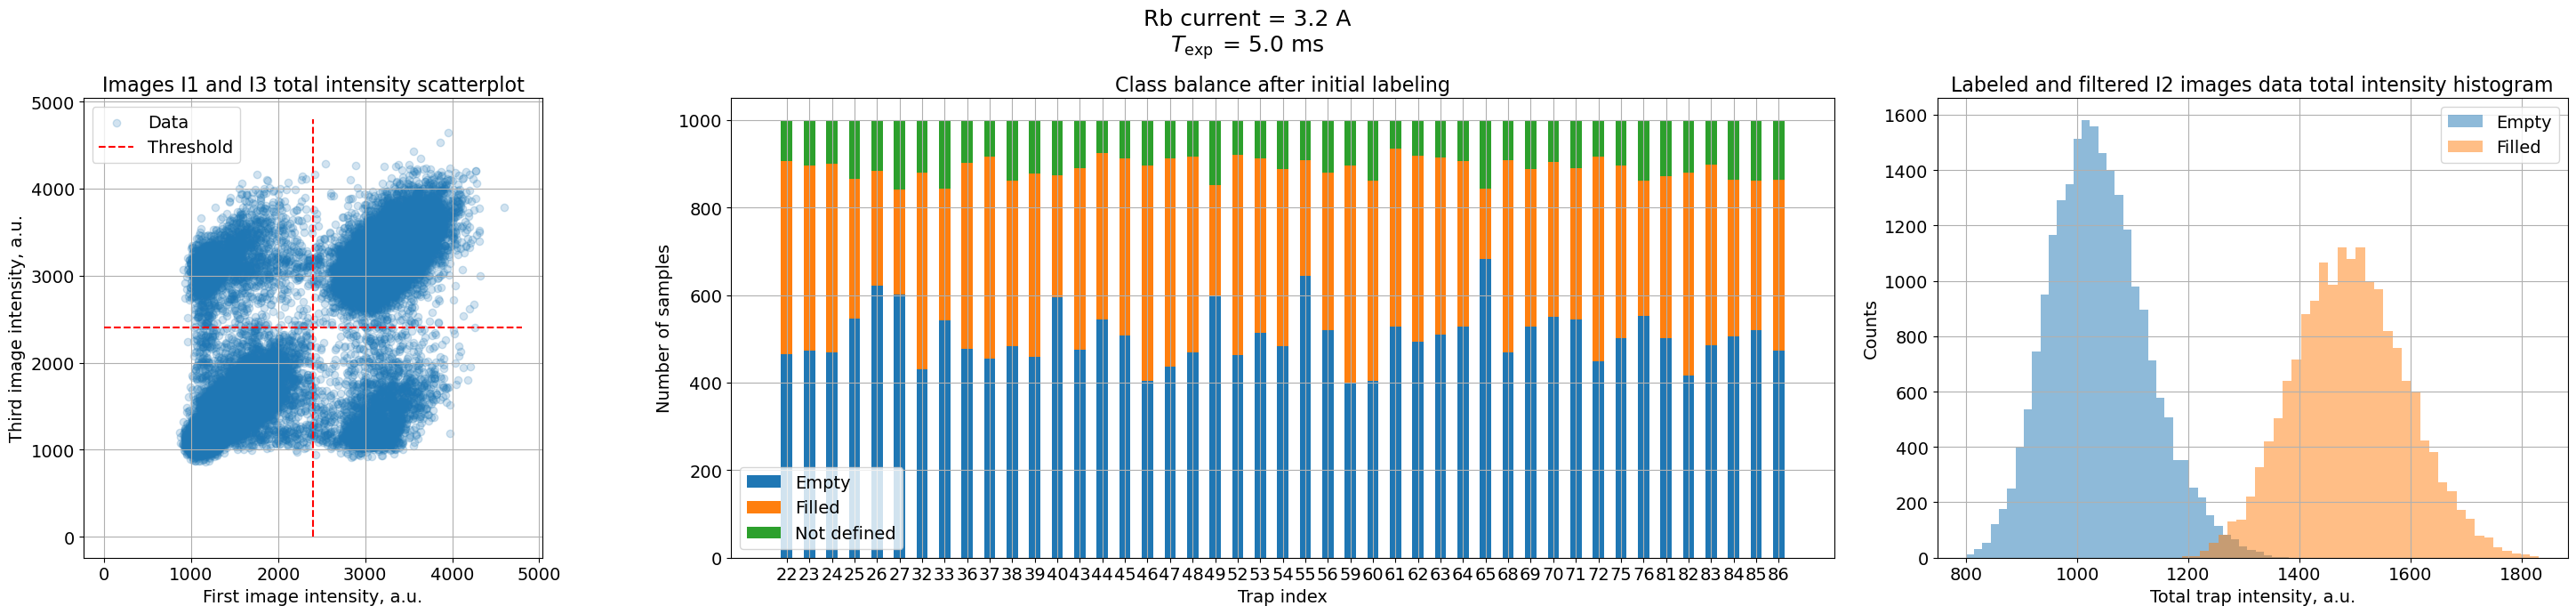

 47%|████▋     | 7/15 [00:08<00:09,  1.24s/it]

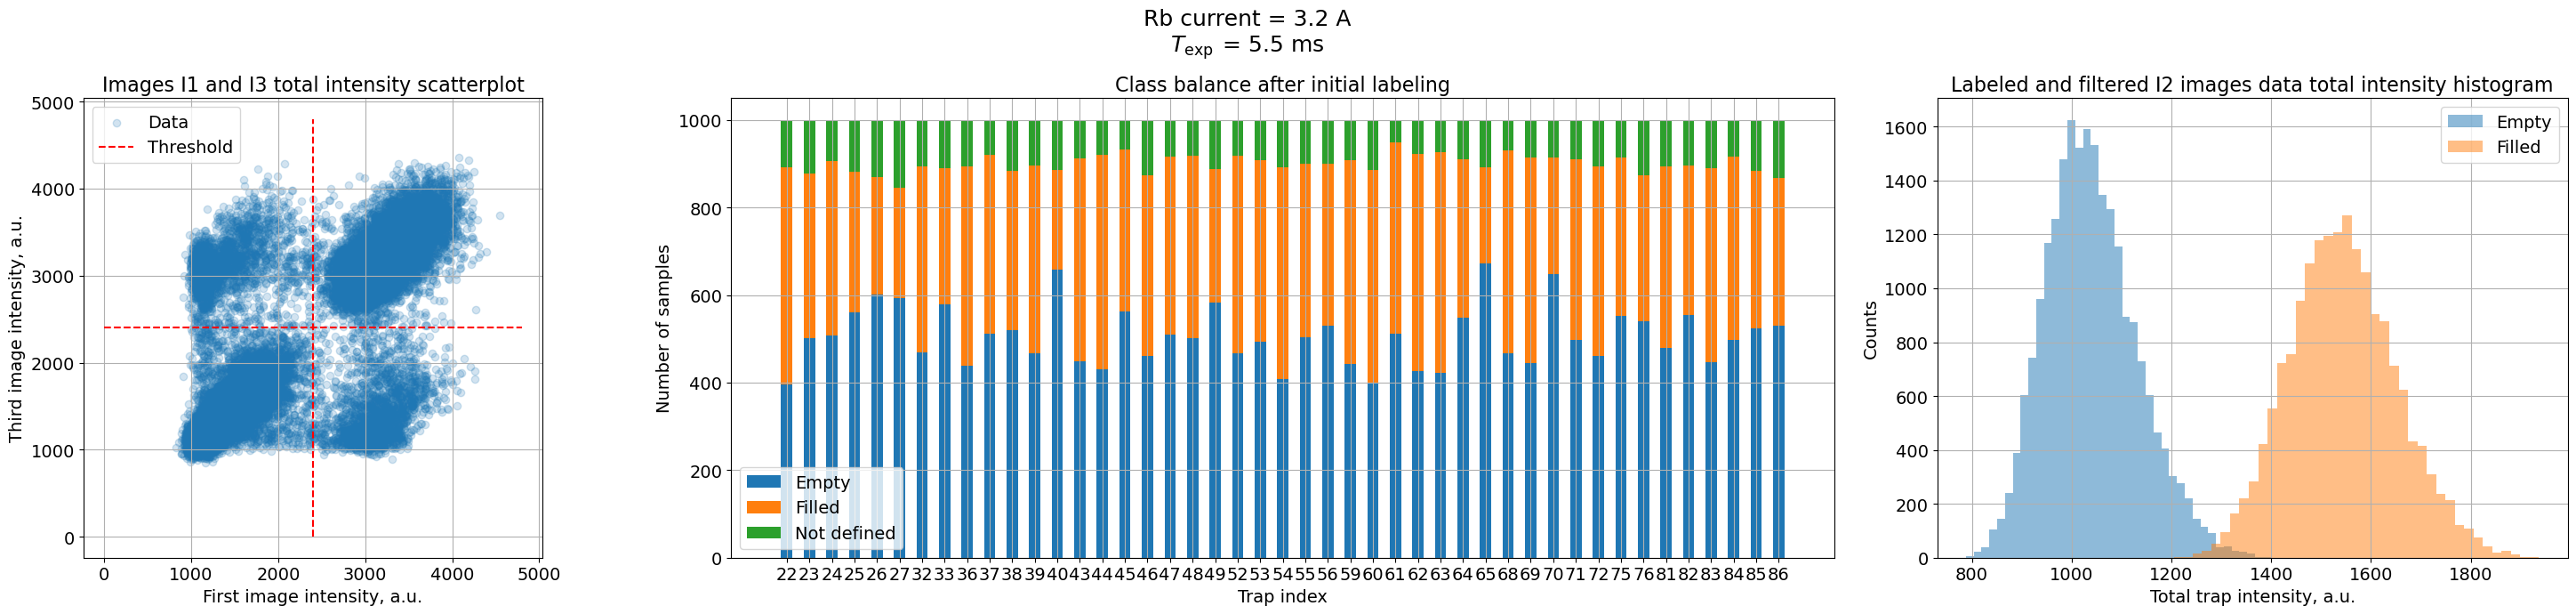

 53%|█████▎    | 8/15 [00:10<00:09,  1.29s/it]

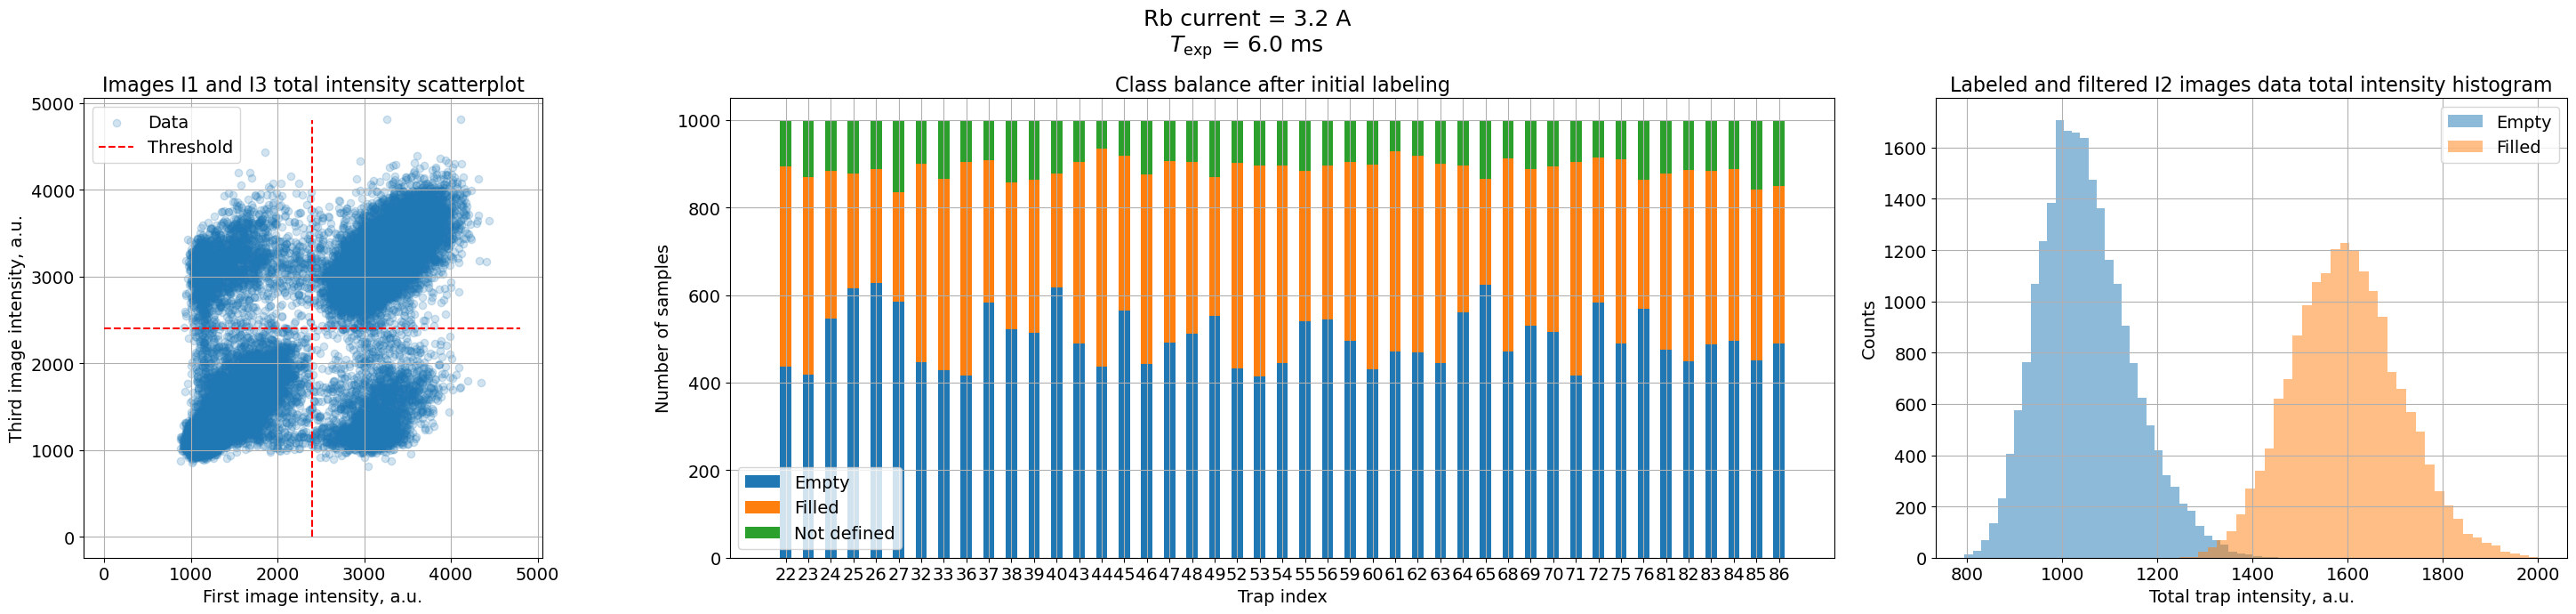

 60%|██████    | 9/15 [00:11<00:07,  1.28s/it]

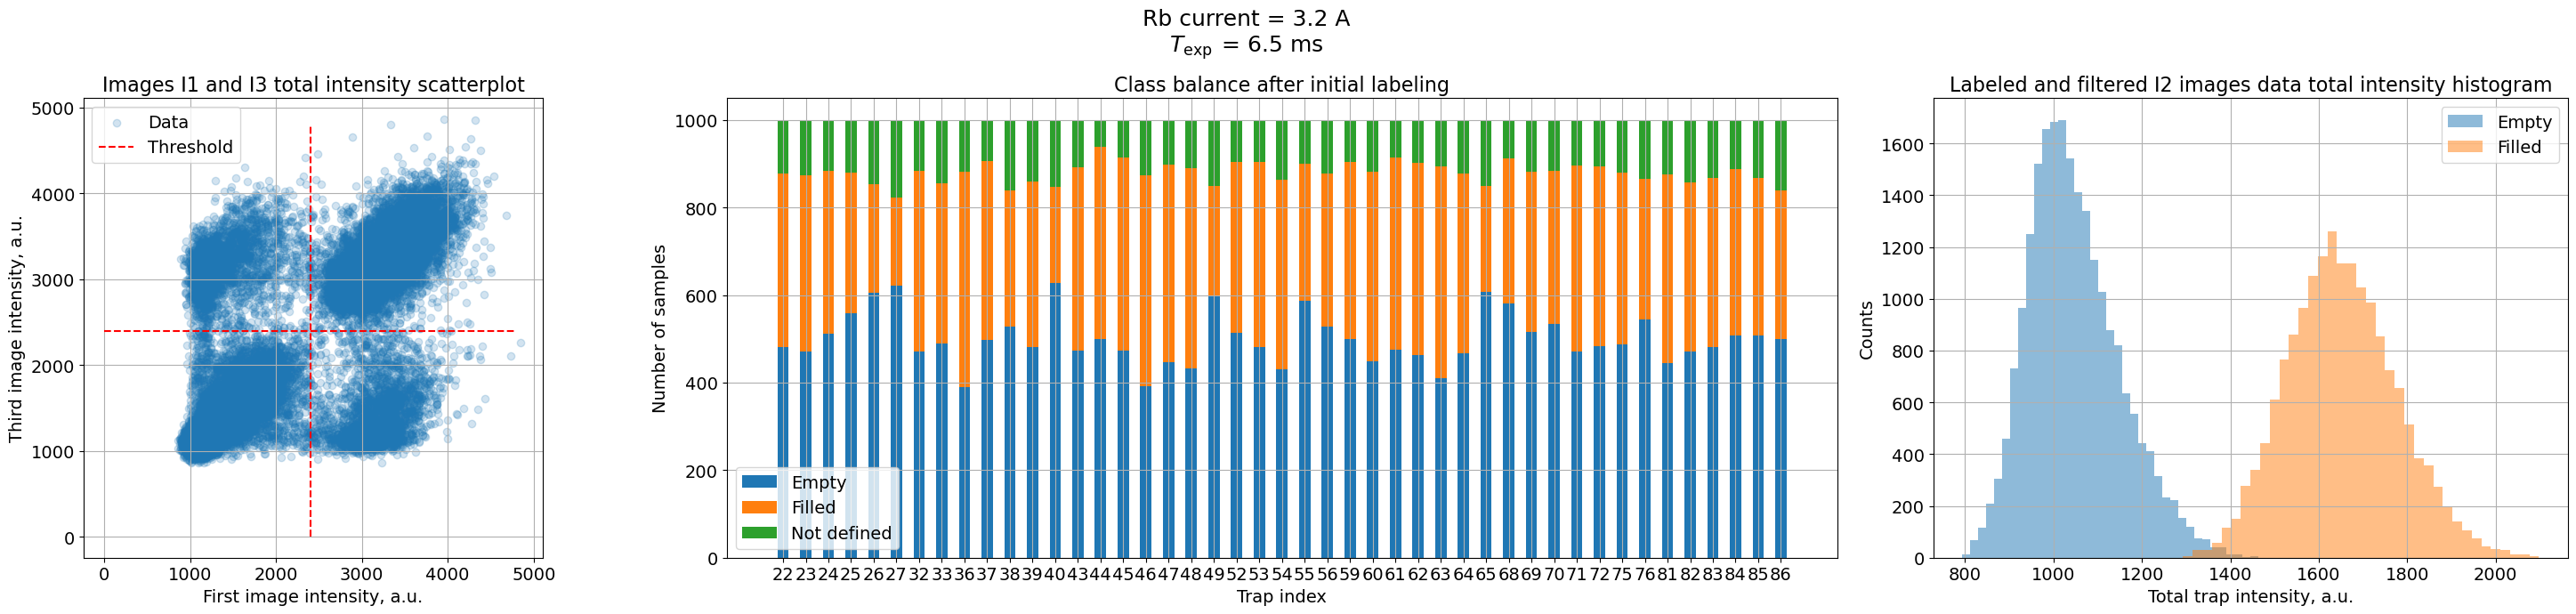

 67%|██████▋   | 10/15 [00:12<00:06,  1.33s/it]

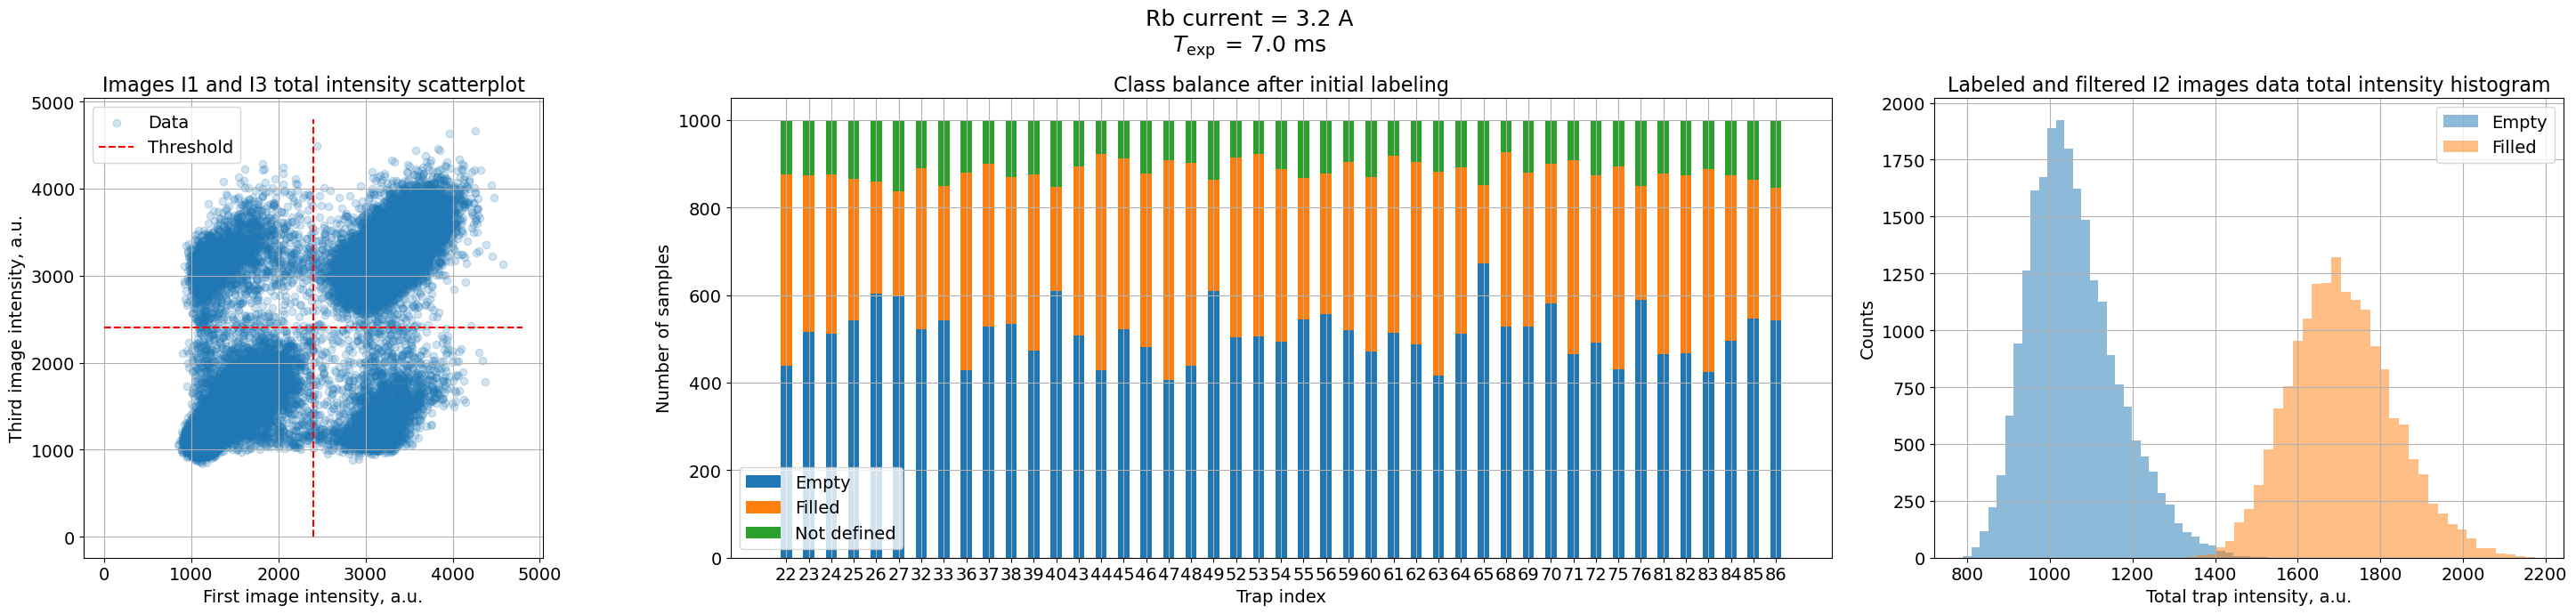

 73%|███████▎  | 11/15 [00:13<00:05,  1.26s/it]

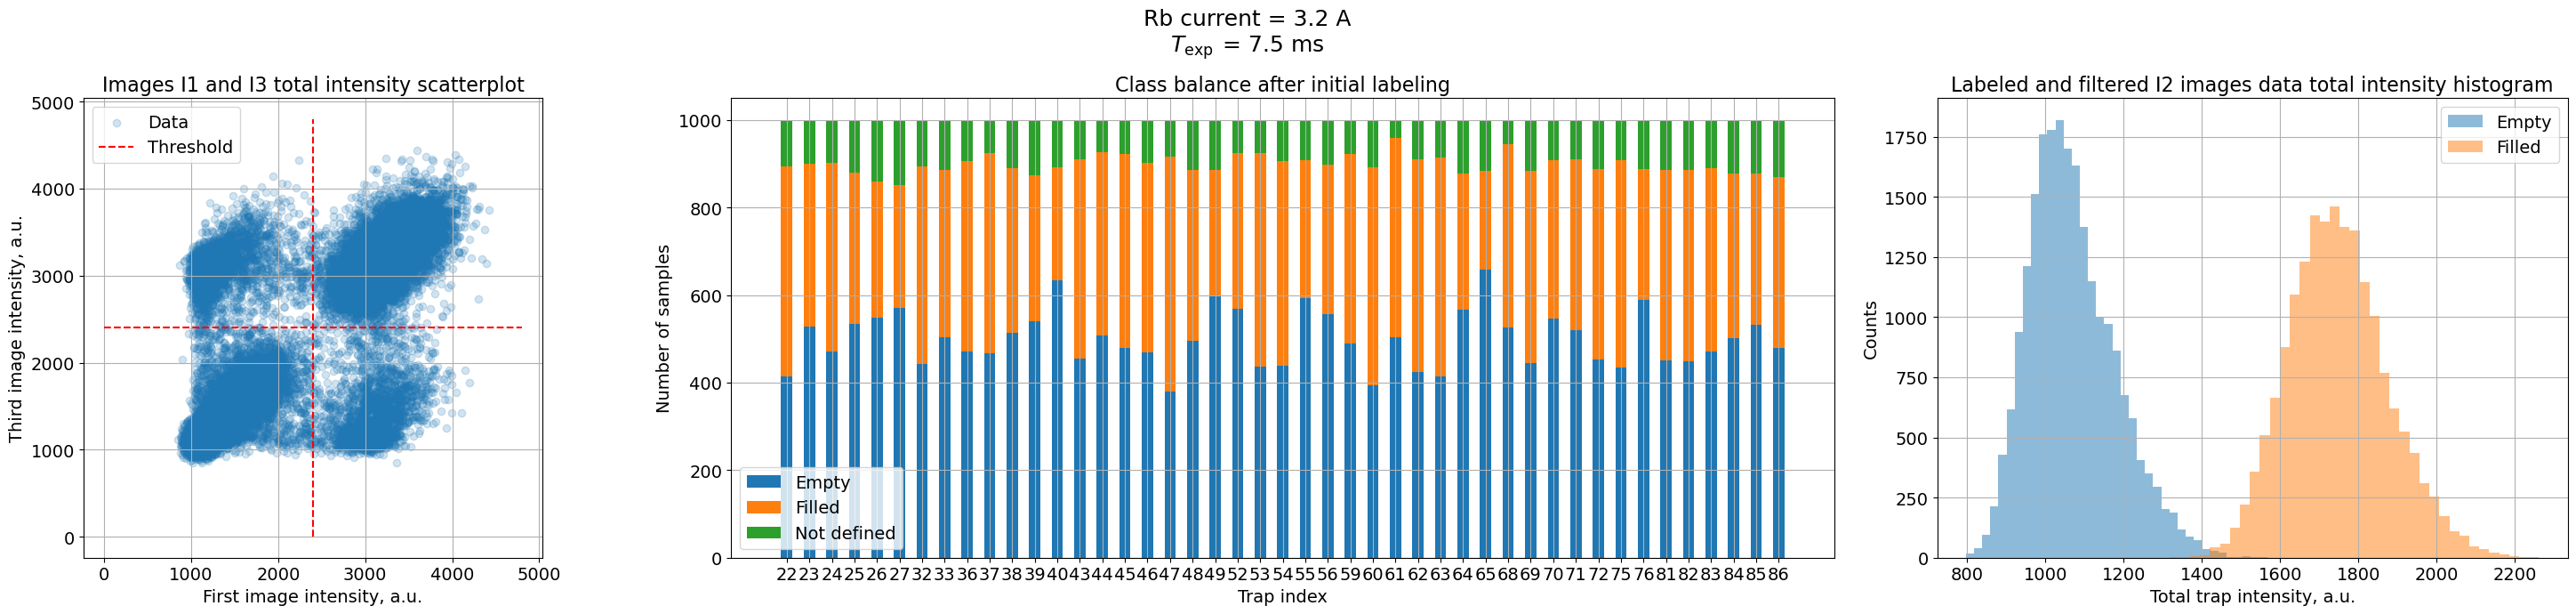

 80%|████████  | 12/15 [00:15<00:03,  1.28s/it]

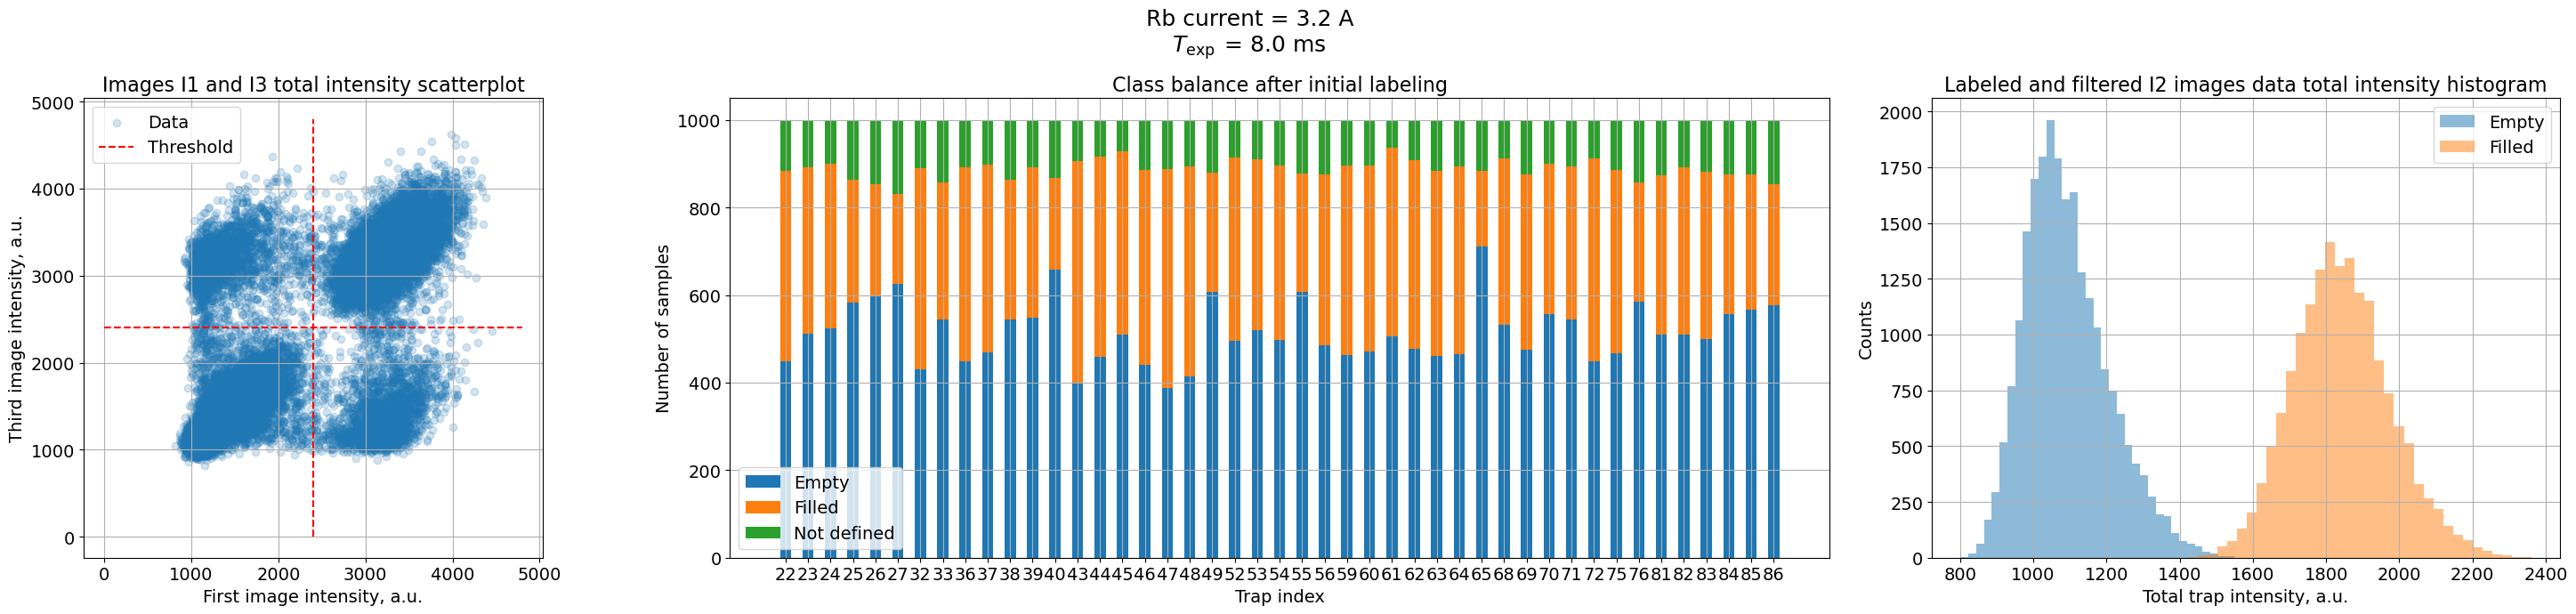

 87%|████████▋ | 13/15 [00:16<00:02,  1.37s/it]

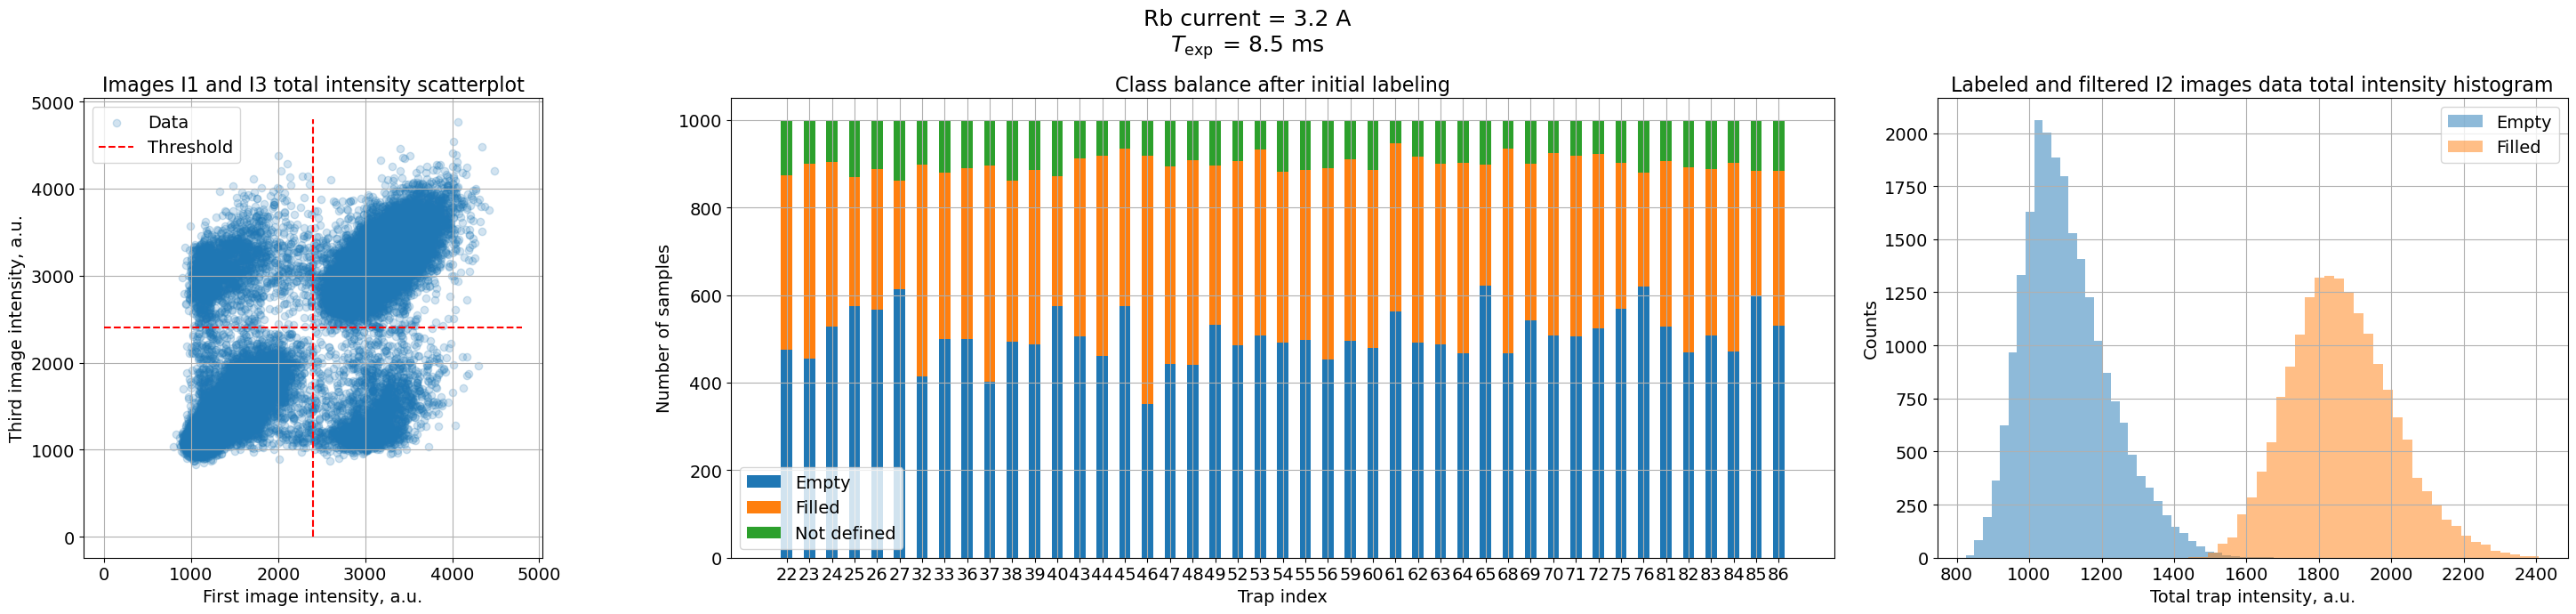

 93%|█████████▎| 14/15 [00:18<00:01,  1.39s/it]

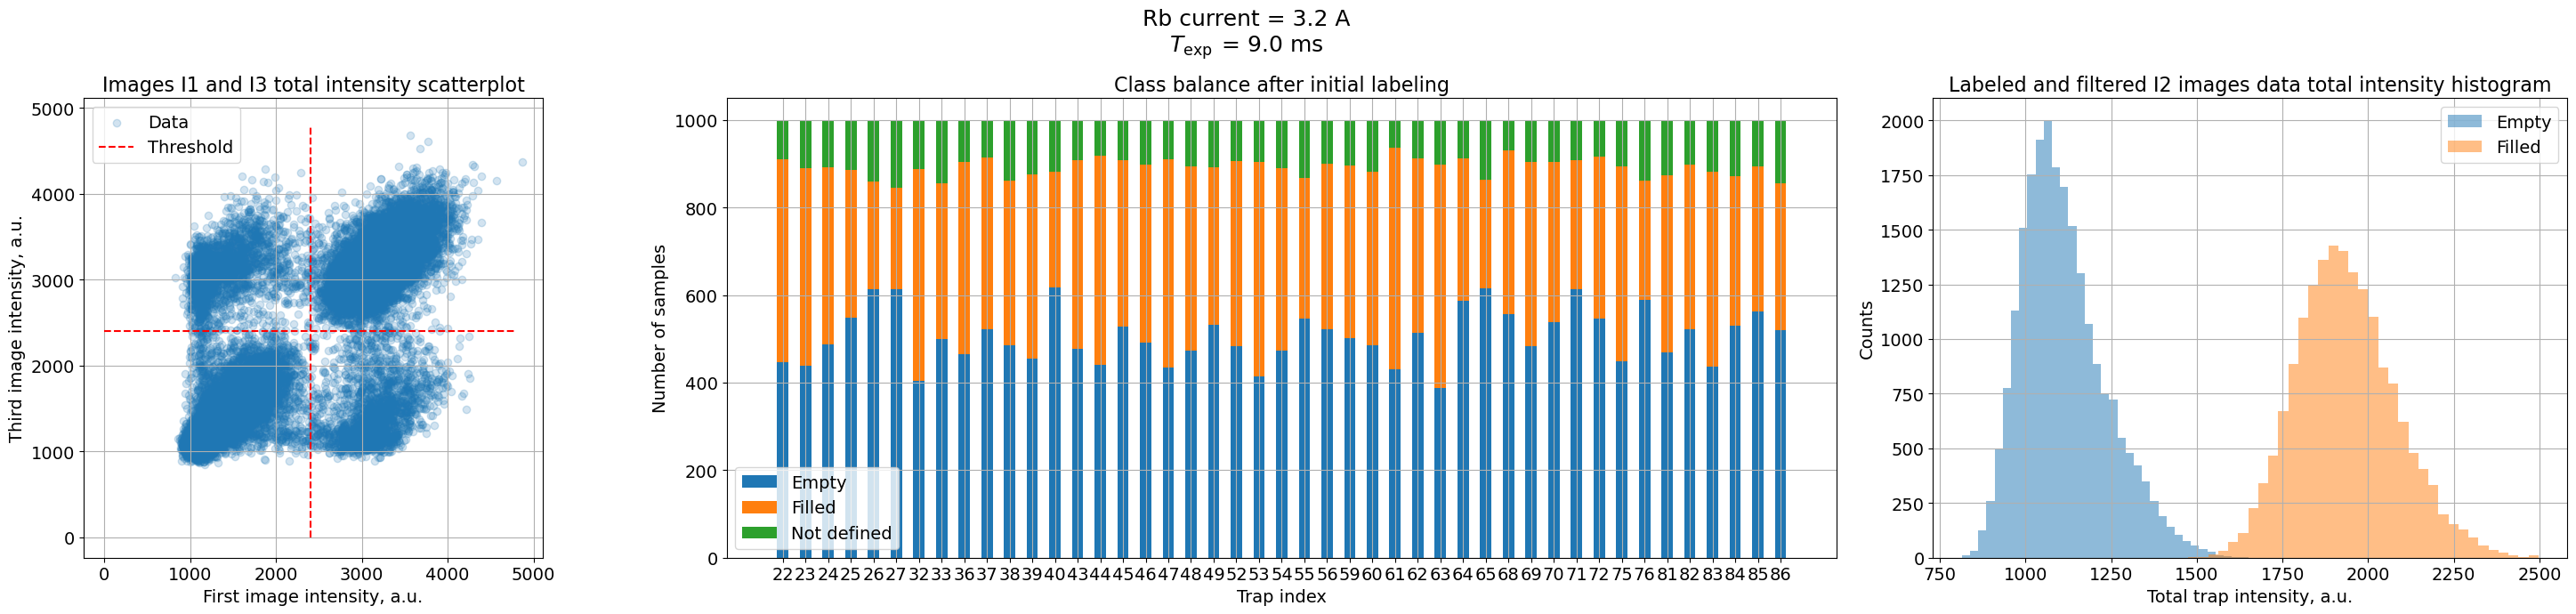

100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


In [19]:
process_data_return_clean_file(plot=True)

# Check labeled data result

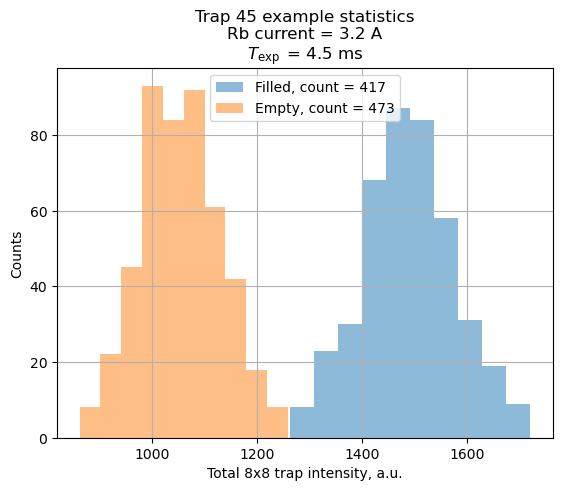

In [20]:
# readout example
with h5py.File(LABELED_TRAPS_PATH, "r") as f:
    rb_current = 3.2
    texp = 4.5
    trap_ind = 45

    d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/trap_{trap_ind}/filled"]
    filled = d[::]

    d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/trap_{trap_ind}/empty"]
    empty = d[::]

# intensity hist
dat = np.concatenate((filled.sum(axis=(1, 2)), empty.sum(axis=(1, 2))), axis=0)
h = scipy.stats.iqr(dat) * 2 * dat.shape[0] ** (-1 / 3)
plt.hist(
    filled.sum(axis=(1, 2)),
    bins=round((dat.max() - dat.min()) / h),
    label=f"Filled, count = {filled.shape[0]}",
    alpha=0.5,
)
plt.hist(
    empty.sum(axis=(1, 2)),
    bins=round((dat.max() - dat.min()) / h),
    label=f"Empty, count = {empty.shape[0]}",
    alpha=0.5,
)
plt.xlabel("Total 8x8 trap intensity, a.u.")
plt.ylabel("Counts")
plt.title(
    f"Trap {trap_ind} example statistics\nRb current = {rb_current:.1f} A\n$T_\exp$ = {texp:.1f} ms"
)
plt.grid()
plt.legend()
plt.show()

In [21]:
RESULTS_PATH = Path(".", "..", "data", "results")

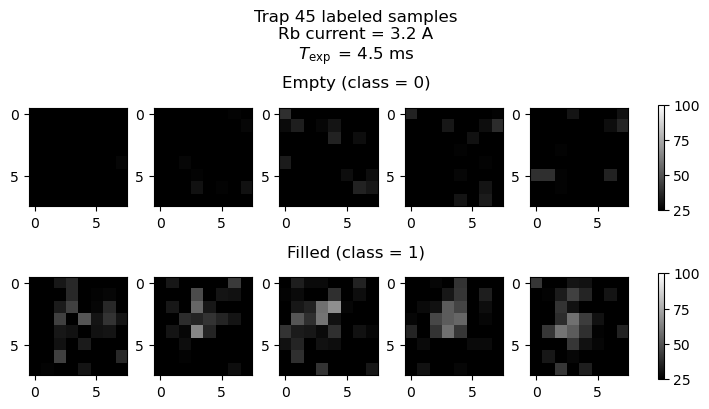

In [22]:
# visualize and save some data samples
N_SAMPLES = 5
fig = plt.figure(constrained_layout=True, figsize=(7, 4))
fig.suptitle(
    f"Trap {trap_ind} labeled samples\nRb current = {rb_current:.1f} A\n$T_\exp$ = {texp:.1f} ms"
)
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    if row == 0:
        subfig.suptitle("Empty (class = 0)")
    else:
        subfig.suptitle("Filled (class = 1)")

    # create subplots
    axs = subfig.subplots(nrows=1, ncols=N_SAMPLES)
    for col, ax in enumerate(axs):
        if row == 0:
            im = axs[col].imshow(empty[col], vmin=25, vmax=100, cmap="grey")
        else:
            im = axs[col].imshow(filled[col], vmin=25, vmax=100, cmap="grey")
    fig.colorbar(im, ax=axs.ravel().tolist())
plt.savefig(RESULTS_PATH / f"sample_labeled_trap_{trap_ind}.pdf", dpi=300, bbox_inches="tight")
plt.savefig(RESULTS_PATH / f"sample_labeled_trap_{trap_ind}.png", dpi=300, bbox_inches="tight")
plt.show()